# Scoring pour le risque crédit

In [1]:
# Chargement des bibliothèques et des modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
    
import warnings
warnings.filterwarnings('ignore')

In [2]:
#pandas DataFrame column and row display limits
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [3]:
# Vérification d'emplacement
import os
os.getcwd()

'C:\\Users\\vasub\\Downloads\\dossier_gev\\projet_7\\Soutenance_PR_7 Barseghyan_Gevorg'

# Objectifs:

### Il s'agit d'un problèm de classification d'apprentissage supervisé qui contient leurs étiquettes de classe. Les étiquettes de classe indiquent si un candidat est un défaillant ou non. L'objectif est de prédire l'étiquette pour chaque client.

#### Structure des tables relationnelles

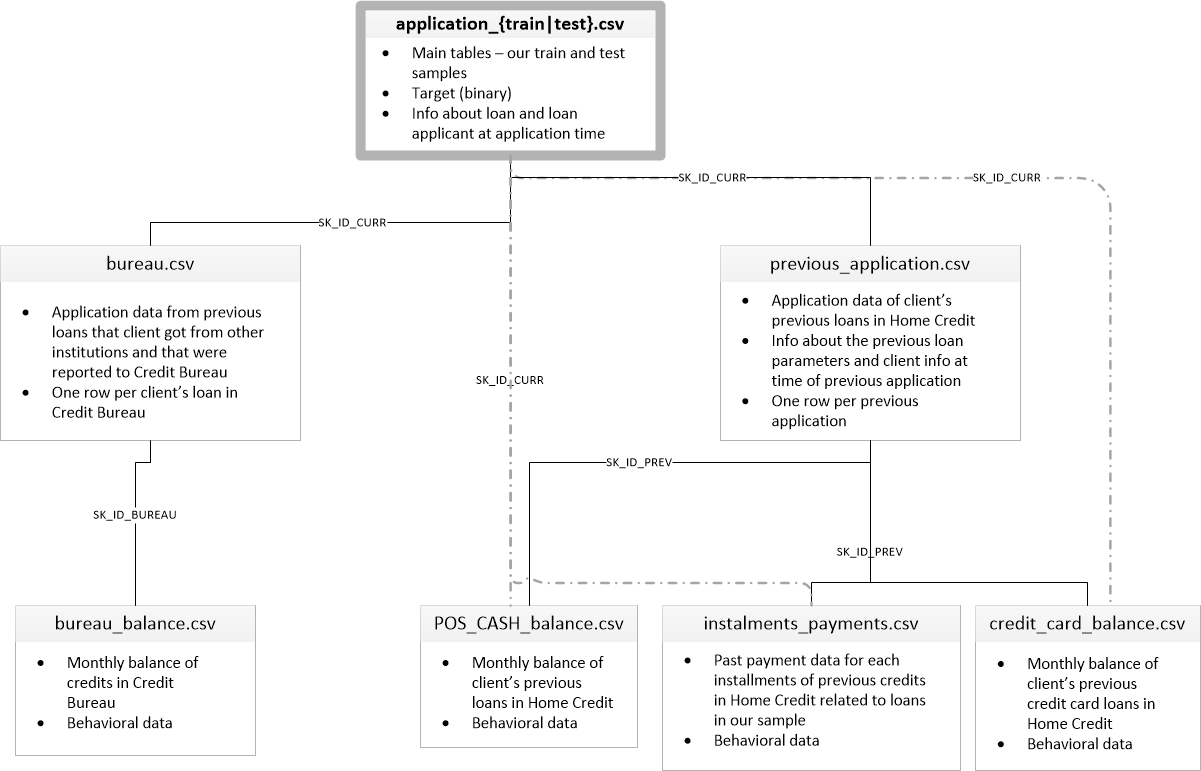

### Chargement des tables

In [4]:
application_train = pd.read_csv("data/application_train.csv", encoding="utf8",encoding_errors='ignore')
application_test = pd.read_csv("data/application_test.csv", encoding="utf8",encoding_errors='ignore')
bureau = pd.read_csv("data/bureau.csv", encoding="utf8",encoding_errors='ignore')
bureau_balance = pd.read_csv("data/bureau_balance.csv", encoding="utf8",encoding_errors='ignore')
credit_card_balance = pd.read_csv('data/credit_card_balance.csv', encoding="utf8",encoding_errors='ignore')
installments_payments = pd.read_csv('data/installments_payments.csv', encoding="utf8",encoding_errors='ignore')
POS_CASH_balance = pd.read_csv('data/POS_CASH_balance.csv', encoding="utf8",encoding_errors='ignore')
previous_application = pd.read_csv('data/previous_application.csv', encoding="utf8",encoding_errors='ignore')

#### Réduire l'utilisation de la mémoire

In [5]:
def reduce_mem_usage(data, verbose = True):
    #source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)
    
    return data

In [6]:
tables = [application_train, application_test,
          bureau, bureau_balance, credit_card_balance, 
          installments_payments, 
          POS_CASH_balance, previous_application]

In [7]:
for table in tables:
    table = reduce_mem_usage(table, verbose = True)
    print(table.shape)
    
    

----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 286.23 MB
Memory usage after optimization: 92.38 MB
Decreased by 67.7%
----------------------------------------------------------------------------------------------------
(307511, 122)
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 45.00 MB
Memory usage after optimization: 14.60 MB
Decreased by 67.6%
----------------------------------------------------------------------------------------------------
(48744, 121)
----------------------------------------------------------------------------------------------------
Memory usage of dataframe: 222.62 MB
Memory usage after optimization: 112.95 MB
Decreased by 49.3%
----------------------------------------------------------------------------------------------------
(1716428, 17)
-----------------------------------------------------------

In [8]:
# garbage collection
import gc   
gc.collect()


0

0 - signifie les clients non-défaillants environ 0.92 %
1 - signifie les clients défaillants environ 0.08 %


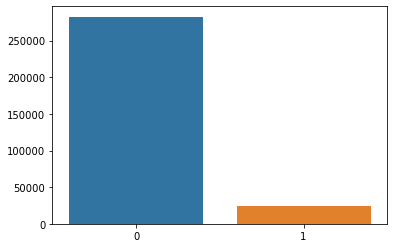

In [9]:
# La distribution de TARGET

sns.barplot(x = application_train['TARGET'].value_counts().index, y = application_train['TARGET'].value_counts().values)
print(f"0 - signifie les clients non-défaillants environ {round(application_train['TARGET'].value_counts().values[0] / len(application_train['TARGET']),2)} %")
print(f"1 - signifie les clients défaillants environ {round(application_train['TARGET'].value_counts().values[1] / len(application_train['TARGET']),2)} %")
plt.savefig('image/Target.png')

##### Formulation de problèmes et mesures de performances

## Examinons chaque table


#### application_train.csv and application_test.csv
 * Il s'agit de la table principale, divisée en deux fichiers pour Train (avec TARGET) et Test (sans TARGET).
 * Données statiques pour toutes les applications. Une ligne représente un prêt dans notre échantillon de données.

In [10]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float16(61), float32(4), int16(2), int32(2), int8(37), object(16)
memory usage: 92.4+ MB


In [11]:
application_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float16(61), float32(4), int16(2), int32(2), int8(36), object(16)
memory usage: 14.6+ MB


### Représentation graphique de NaN

In [12]:
# Valeurs manquantes (represantation graphique )

def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 1.0].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(), axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")
    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")

Number of Variables include Missing Values: 67 



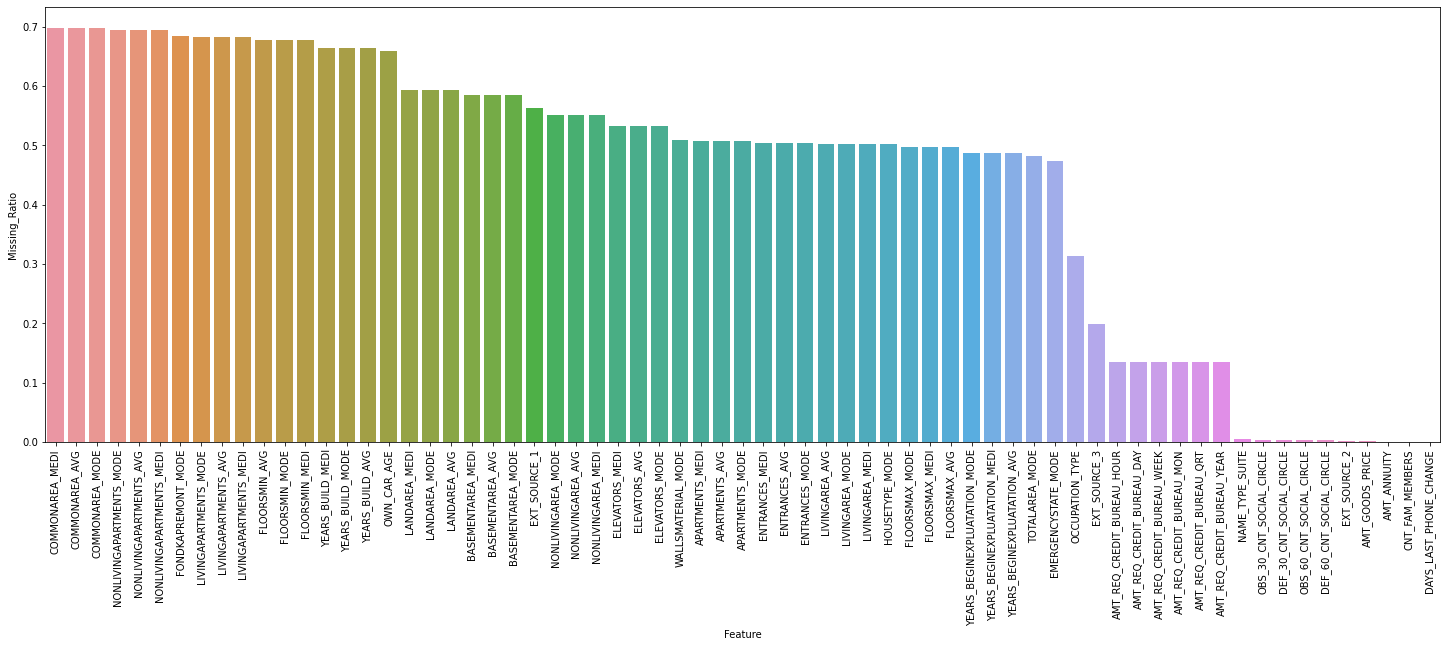

                         Feature  Num_Missing  Missing_Ratio DataTypes
0                COMMONAREA_MEDI       214865       0.698723   float16
1                 COMMONAREA_AVG       214865       0.698723   float16
2                COMMONAREA_MODE       214865       0.698723   float16
3       NONLIVINGAPARTMENTS_MODE       213514       0.694330   float16
4        NONLIVINGAPARTMENTS_AVG       213514       0.694330   float16
5       NONLIVINGAPARTMENTS_MEDI       213514       0.694330   float16
6             FONDKAPREMONT_MODE       210295       0.683862    object
7          LIVINGAPARTMENTS_MODE       210199       0.683550   float16
8           LIVINGAPARTMENTS_AVG       210199       0.683550   float16
9          LIVINGAPARTMENTS_MEDI       210199       0.683550   float16
10                 FLOORSMIN_AVG       208642       0.678486   float16
11                FLOORSMIN_MODE       208642       0.678486   float16
12                FLOORSMIN_MEDI       208642       0.678486   float16
13    

In [13]:
missing_values(application_train, plot=True)

* application_train.csv :

On voit sur le graphique  qu'il y a 67 /122 qui contiennent des valeurs NaN. On ne peut pas les supprimer , car la perte d'informations pourrait être très élevée(c'est-a-dire, il y a très peu de personnes qui font défaut (0.08%), et elles ont tendance à montrer une sorte de comportement différent. Ainsi, dans de tels cas nous devons observer les valeurs aberrantes (détection de fraude, de défaut et d'anamolie),  et on peut pas les supprimer, car elles pourraient être le facteur de différenciation entre le défaillant et le non-défaillant).
De l'autre coté, on voit  que la plupart des colonnes qui ont plus de 50 % de valeurs NaN sont liées aux statistiques des appartements. Il est très probable que ces valeurs n'aient pas été enregistrées lors de la saisie des données et pourraient être facultatives.

Number of Variables include Missing Values: 64 



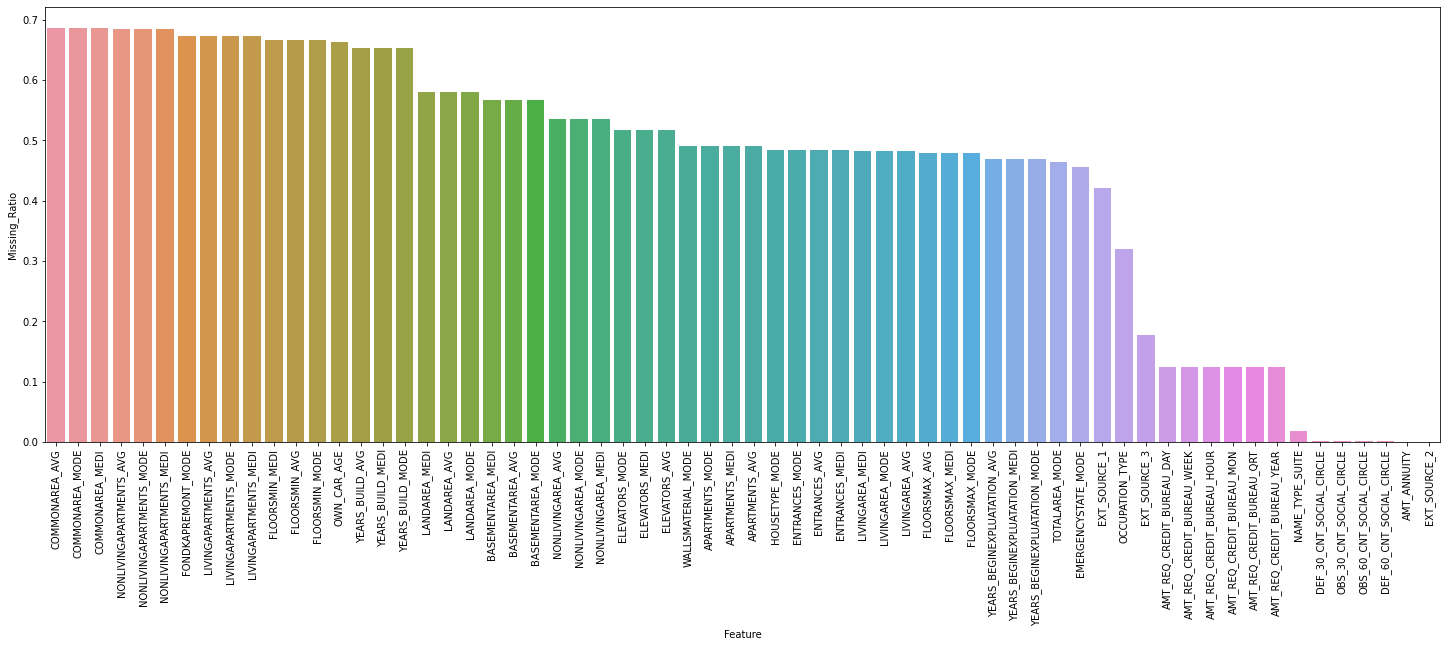

                         Feature  Num_Missing  Missing_Ratio DataTypes
0                 COMMONAREA_AVG        33495       0.687161   float16
1                COMMONAREA_MODE        33495       0.687161   float16
2                COMMONAREA_MEDI        33495       0.687161   float16
3        NONLIVINGAPARTMENTS_AVG        33347       0.684125   float16
4       NONLIVINGAPARTMENTS_MODE        33347       0.684125   float16
5       NONLIVINGAPARTMENTS_MEDI        33347       0.684125   float16
6             FONDKAPREMONT_MODE        32797       0.672842    object
7           LIVINGAPARTMENTS_AVG        32780       0.672493   float16
8          LIVINGAPARTMENTS_MODE        32780       0.672493   float16
9          LIVINGAPARTMENTS_MEDI        32780       0.672493   float16
10                FLOORSMIN_MEDI        32466       0.666051   float16
11                 FLOORSMIN_AVG        32466       0.666051   float16
12                FLOORSMIN_MODE        32466       0.666051   float16
13    

In [14]:
# Idem pour la table Test
missing_values(application_test, plot=True)

* application_test.csv :

Il y a un nombre très  similaire de colonnes avec des valeurs NaN (64) comme c'était le cas avec application_train.
Les pourcentages de valeurs NaN sont également assez similaires à ceux présents dans l'ensemble de données d'entraînement. Cela signifie que les ensembles d'entraînement et de test ont une distribution à peu près similaire.

In [15]:
# garbage collection
import gc   
gc.collect()

34370

#### Les features numériques et la quantité des valeurs sur chaque variable 

In [16]:
col_num_train  = []
for i in application_train.select_dtypes(['float16', 'float32', 'int16', 'int32', 'int8']):
    col_num_train.append(i)
    print(f'{i:-<30} {len(application_train[i].unique())}')

SK_ID_CURR-------------------- 307511
TARGET------------------------ 2
CNT_CHILDREN------------------ 15
AMT_INCOME_TOTAL-------------- 2548
AMT_CREDIT-------------------- 5603
AMT_ANNUITY------------------- 13673
AMT_GOODS_PRICE--------------- 1003
REGION_POPULATION_RELATIVE---- 81
DAYS_BIRTH-------------------- 17460
DAYS_EMPLOYED----------------- 12574
DAYS_REGISTRATION------------- 5282
DAYS_ID_PUBLISH--------------- 6168
OWN_CAR_AGE------------------- 63
FLAG_MOBIL-------------------- 2
FLAG_EMP_PHONE---------------- 2
FLAG_WORK_PHONE--------------- 2
FLAG_CONT_MOBILE-------------- 2
FLAG_PHONE-------------------- 2
FLAG_EMAIL-------------------- 2
CNT_FAM_MEMBERS--------------- 18
REGION_RATING_CLIENT---------- 3
REGION_RATING_CLIENT_W_CITY--- 3
HOUR_APPR_PROCESS_START------- 24
REG_REGION_NOT_LIVE_REGION---- 2
REG_REGION_NOT_WORK_REGION---- 2
LIVE_REGION_NOT_WORK_REGION--- 2
REG_CITY_NOT_LIVE_CITY-------- 2
REG_CITY_NOT_WORK_CITY-------- 2
LIVE_CITY_NOT_WORK_CITY------- 2
EXT_SO

In [17]:
# Nous sélectionnons les features qui ont au maximum 3 valeurs

col_num_train_3val_max = [col for col in application_train[col_num_train] if len(application_train[col].unique()) < 4]

In [18]:
for i in col_num_train_3val_max:
    
    print(f'{i:-<30} {application_train[i].unique()}')

TARGET------------------------ [1 0]
FLAG_MOBIL-------------------- [1 0]
FLAG_EMP_PHONE---------------- [1 0]
FLAG_WORK_PHONE--------------- [0 1]
FLAG_CONT_MOBILE-------------- [1 0]
FLAG_PHONE-------------------- [1 0]
FLAG_EMAIL-------------------- [0 1]
REGION_RATING_CLIENT---------- [2 1 3]
REGION_RATING_CLIENT_W_CITY--- [2 1 3]
REG_REGION_NOT_LIVE_REGION---- [0 1]
REG_REGION_NOT_WORK_REGION---- [0 1]
LIVE_REGION_NOT_WORK_REGION--- [0 1]
REG_CITY_NOT_LIVE_CITY-------- [0 1]
REG_CITY_NOT_WORK_CITY-------- [0 1]
LIVE_CITY_NOT_WORK_CITY------- [0 1]
FLAG_DOCUMENT_2--------------- [0 1]
FLAG_DOCUMENT_3--------------- [1 0]
FLAG_DOCUMENT_4--------------- [0 1]
FLAG_DOCUMENT_5--------------- [0 1]
FLAG_DOCUMENT_6--------------- [0 1]
FLAG_DOCUMENT_7--------------- [0 1]
FLAG_DOCUMENT_8--------------- [0 1]
FLAG_DOCUMENT_9--------------- [0 1]
FLAG_DOCUMENT_10-------------- [0 1]
FLAG_DOCUMENT_11-------------- [0 1]
FLAG_DOCUMENT_12-------------- [0 1]
FLAG_DOCUMENT_13-------------- [0 

In [19]:
# Fusionnons les avec des features "object" (en considérant que ces variables sont categoriels pour observer la correlation entre eux)
col_num_cat_train = col_num_train_3val_max + list(application_train.select_dtypes('object'))
len(col_num_cat_train)

51

# Correlations entre les variables catégoriels 

### Phi-K
Le coefficient Phi-K est similaire au coefficient de corrélation, sauf qu'il peut être utilisé avec une paire d'entités catégorielles pour vérifier si une entité présente une sorte d'association avec l'autre entité catégorielle. Sa valeur maximale peut être 1, ce qui montrerait une association maximale entre deux variables catégorielles.

In [20]:
def plot_phik_matrix(data, categorical_columns, figsize = (25,23), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    # Premièrement on  ne récupère que les caractéristiques catégorielles
    data_for_phik = data[categorical_columns].astype('object')
    
    
    phik_matrix = data_for_phik.phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        
        # Voyons quelles colonnes ont la plus forte corrélation avec la variable cible dans application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100) 

----------------------------------------------------------------------------------------------------


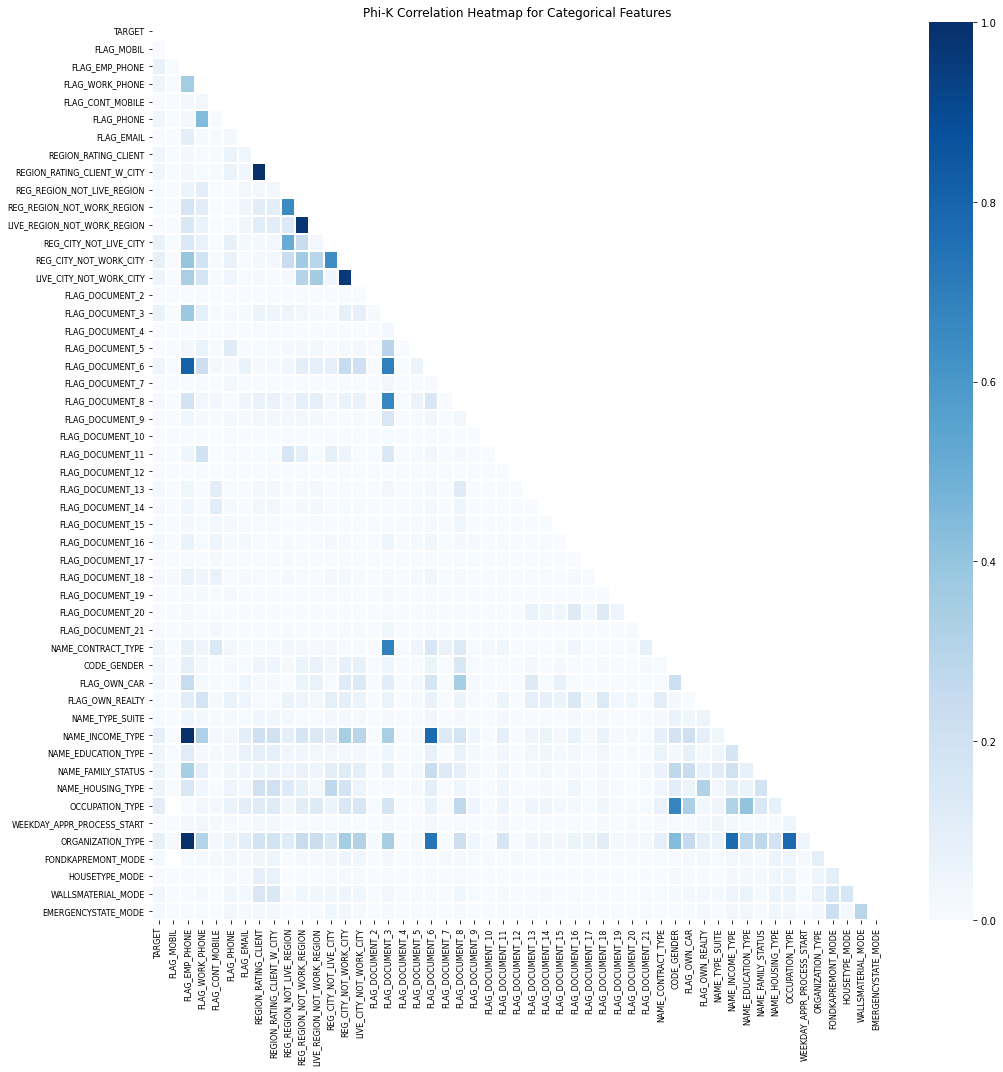

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
43,OCCUPATION_TYPE,0.102846
45,ORGANIZATION_TYPE,0.089164
39,NAME_INCOME_TYPE,0.084831
12,REG_CITY_NOT_WORK_CITY,0.079946
1,FLAG_EMP_PHONE,0.072087
11,REG_CITY_NOT_LIVE_CITY,0.069588
15,FLAG_DOCUMENT_3,0.069525
41,NAME_FAMILY_STATUS,0.056043
42,NAME_HOUSING_TYPE,0.051107
13,LIVE_CITY_NOT_WORK_CITY,0.050956


----------------------------------------------------------------------------------------------------


In [21]:
# Represantation graphique
plot_phik_matrix(application_train,col_num_cat_train, figsize = (15,15), fontsize = 8)


 * On voit qu'il n'y a pratiquement pas de corrélation entre la variable "TARGET" et les variables catégorielles


In [22]:
# Certaines catégories sont fortement corrélées entre elles :
threshold = 0.7
corr = application_train[col_num_cat_train].corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
4,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,0.950842
2,LIVE_REGION_NOT_WORK_REGION,REG_REGION_NOT_WORK_REGION,0.860627
0,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,0.825575


In [23]:
# garbage collection
import gc   
gc.collect()

12887

# Matrice de corrélation des features numériques 

In [24]:
#Suppression des certaines features (id, colonnes avec 3 variables, mais on va garder le Target) pour l'observation
columns_to_drop = ['SK_ID_CURR'] + list(set(col_num_cat_train) - set(['TARGET']))

In [25]:
col_reste_num_train = list(set(application_train.columns).difference(set(columns_to_drop)))


In [26]:
class correlation_matrix:
   
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop , axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)


----------------------------------------------------------------------------------------------------


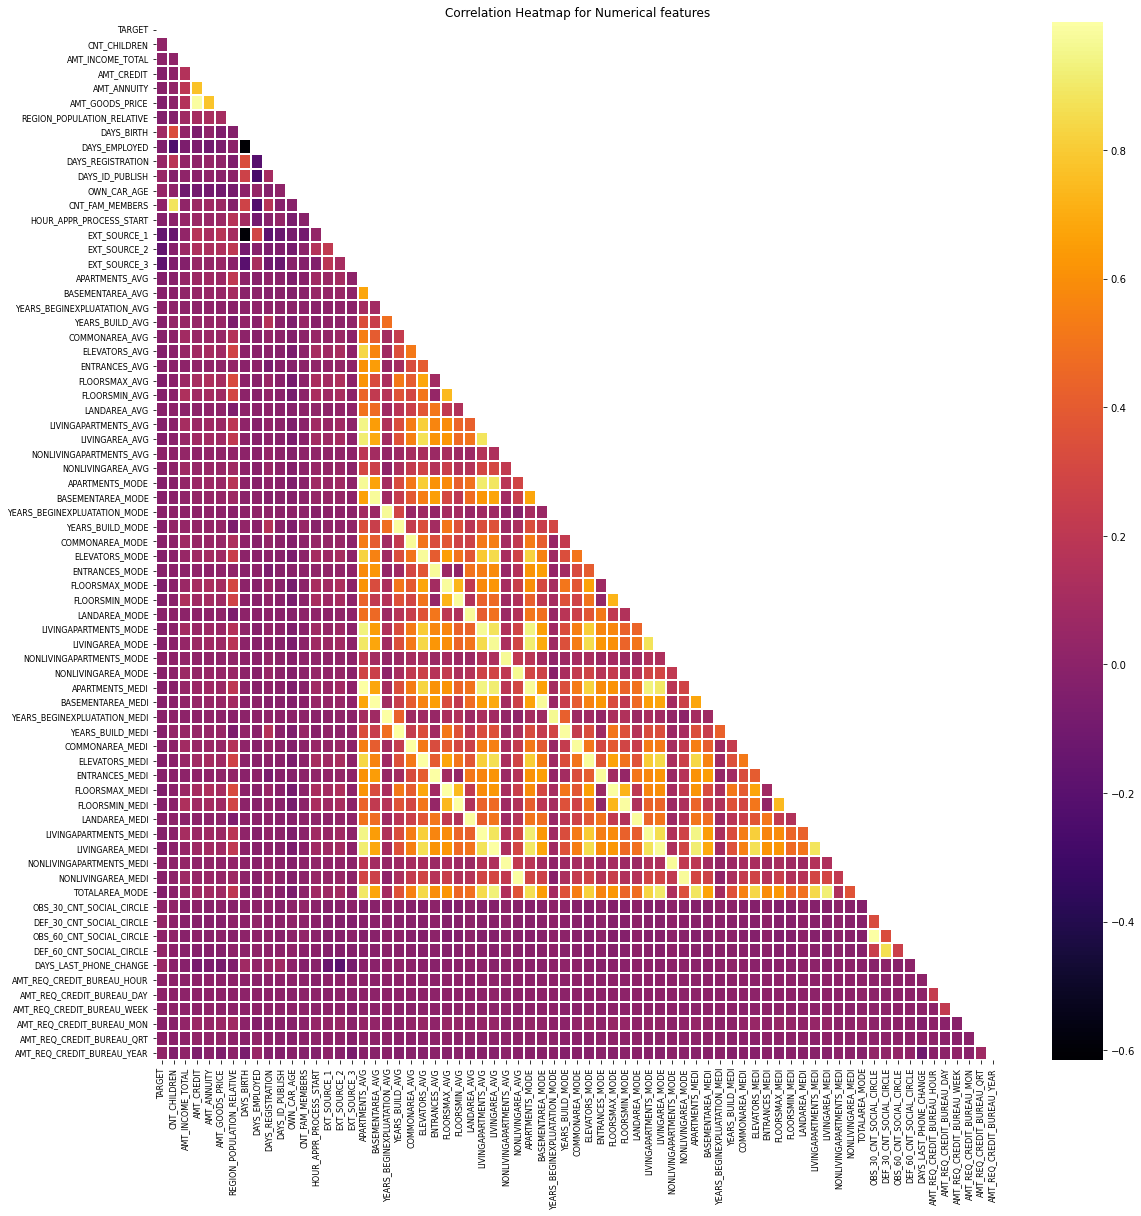

----------------------------------------------------------------------------------------------------


In [27]:
# Represantation graphique
corr_mat = correlation_matrix(application_train, columns_to_drop, figsize = (17,17), fontsize = 8, cmap = 'inferno')
corr_mat.plot_correlation_matrix()

 * On voit qu'il n'y a pratiquement pas de corrélation entre la variable "TARGET" et les variables numériques aussi

In [28]:
# Affichage de la plus forte corrélation entre des varibles (plus que 70%)
threshold = 0.7
corr = application_train[col_reste_num_train].corr()
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
244,YEARS_BUILD_AVG,YEARS_BUILD_MEDI,0.998492
242,OBS_60_CNT_SOCIAL_CIRCLE,OBS_30_CNT_SOCIAL_CIRCLE,0.998490
240,FLOORSMIN_MEDI,FLOORSMIN_AVG,0.997240
238,FLOORSMAX_AVG,FLOORSMAX_MEDI,0.997035
236,ENTRANCES_AVG,ENTRANCES_MEDI,0.996886
234,ELEVATORS_MEDI,ELEVATORS_AVG,0.996100
232,COMMONAREA_AVG,COMMONAREA_MEDI,0.995978
230,LIVINGAREA_MEDI,LIVINGAREA_AVG,0.995596
228,APARTMENTS_MEDI,APARTMENTS_AVG,0.995081
226,BASEMENTAREA_MEDI,BASEMENTAREA_AVG,0.994316


 * les statistiques des appartements sont données en termes de moyenne, médiane et mode,  donc on voit que  la moyenne, la médiane et le mode soient corrélés les uns avec les autres. Et ils sont également corrélées avec d'autres caractéristiques moyennes, telles que le nombre d'ascenseurs, la surface habitable, la zone non habitable, la surface du sous-sol, etc.
 * une forte corrélation entre AMT_GOODS_PRICE et AMT_CREDIT, entre DAYS_EMPLOYED et DAYS_BIRTH etc.

In [29]:
# garbage collection
import gc   
gc.collect()

15415

# Les variables catégorielles

In [30]:
for i in application_train.select_dtypes('object'):
    print(f'{i:-<25} {application_train[i].unique()}')

NAME_CONTRACT_TYPE------- ['Cash loans' 'Revolving loans']
CODE_GENDER-------------- ['M' 'F' 'XNA']
FLAG_OWN_CAR------------- ['N' 'Y']
FLAG_OWN_REALTY---------- ['Y' 'N']
NAME_TYPE_SUITE---------- ['Unaccompanied' 'Family' 'Spouse, partner' 'Children' 'Other_A' nan
 'Other_B' 'Group of people']
NAME_INCOME_TYPE--------- ['Working' 'State servant' 'Commercial associate' 'Pensioner' 'Unemployed'
 'Student' 'Businessman' 'Maternity leave']
NAME_EDUCATION_TYPE------ ['Secondary / secondary special' 'Higher education' 'Incomplete higher'
 'Lower secondary' 'Academic degree']
NAME_FAMILY_STATUS------- ['Single / not married' 'Married' 'Civil marriage' 'Widow' 'Separated'
 'Unknown']
NAME_HOUSING_TYPE-------- ['House / apartment' 'Rented apartment' 'With parents'
 'Municipal apartment' 'Office apartment' 'Co-op apartment']
OCCUPATION_TYPE---------- ['Laborers' 'Core staff' 'Accountants' 'Managers' nan 'Drivers'
 'Sales staff' 'Cleaning staff' 'Cooking staff' 'Private service staff'
 'Medici

In [31]:
# Poucentage des clients en difficultés selon des features
list_df = []
def default_val(data, col):
    list_df = list(data[col].value_counts().index)
    for i in list_df:
        df = data[data[col] == i]
        print(f"{i}  {np.round(len(df[df['TARGET'] == 1]['TARGET'])/len(df[col])*100,1)} %" )   

In [32]:
# Affichage des clients en difficultés selon des features
def affichage(data, col):
    percentage_default = data[data['TARGET'] == 1][col].value_counts() * 100/ data[col].value_counts()
    plt.title(col)
    sns.barplot(x=percentage_default.index, y=percentage_default.values )
#     return percentage_default  

In [33]:
# Comparaison (affichage) de 2 datasets (dataset original et son sous-ensemble en fonction de la variable d'intérêt)
def default_val_plotting(data, col,size = (10,6)):
    
    print(f"Total Number of categories of {col} = {len(data[col].unique())}")

    plt.figure(figsize = size)
    sns.set(style = 'whitegrid', font_scale = 1.0)
    plt.subplots_adjust(wspace=1.5)

    plt.subplot(1,2,1)
    plt.xticks(rotation =90)
    count_col = data[col].value_counts().sort_values(ascending = False)
    sns.barplot(x = count_col, y = count_col.index)
    plt.title(col, pad = 40)

    plt.subplot(1,2,2)
    plt.xticks(rotation =90)
    percentage_default = data[data.TARGET == 1][col].value_counts() * 100 / count_col
    percentage_default = percentage_default.dropna().sort_values(ascending = False)
    sns.barplot(x = percentage_default, y = percentage_default.index)
    plt.title(f'Percentage of Defaulters for each category of {col}', pad = 40)


### NAME_CONTRACT_TYPE

La colonne contient des informations sur le type de credit. Il existe deux types de prêts (Revolving Loans and Cash Loans)

In [34]:
# Disribution de variable 'NAME_CONTRACT_TYPE' dans le dataset "application_train"
application_train['NAME_CONTRACT_TYPE'].value_counts(normalize=True)*100

Cash loans         90.478715
Revolving loans     9.521285
Name: NAME_CONTRACT_TYPE, dtype: float64

In [35]:
# Distribution de valeur "NAME_CONTRACT_TYPE" parmi tous les clients défaillants 
default_val(application_train,'NAME_CONTRACT_TYPE')

Cash loans  8.3 %
Revolving loans  5.5 %


Total Number of categories of NAME_CONTRACT_TYPE = 2


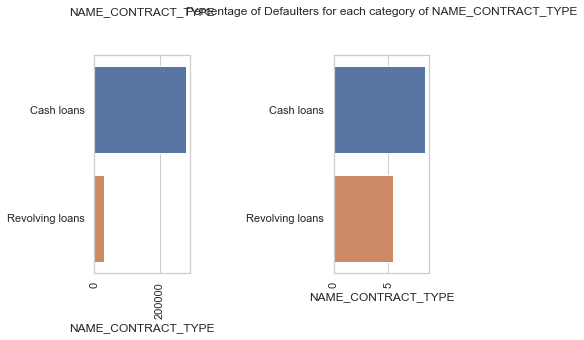

In [36]:
default_val_plotting(application_train,'NAME_CONTRACT_TYPE',(6,4))
plt.savefig('image/contract type.png')

 * Dans la distribution globale , 90.5 % des credits contractés par les clients sont des prêts en espèces. Seuls 9,52% des personnes ont contracté des prêts renouvelables.
 * De l'autre coté, on voit  qu'il y avait un pourcentage plus élevé de personnes qui n'avaient pas remboursé les prêts en espèces (8,35 %) par rapport à celles qui avaient manqué aux prêts renouvelables (5,48 %).

### CODE_GENDER

In [37]:
# Disribution de variable 'CODE_GENDER' dans le dataset "application_train"
application_train['CODE_GENDER'].value_counts()

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

In [38]:
# Distribution de valeur "CODE_GENDER" parmi tous les clients défaillants 
default_val(application_train,'CODE_GENDER')


F  7.0 %
M  10.1 %
XNA  0.0 %


Total Number of categories of CODE_GENDER = 3


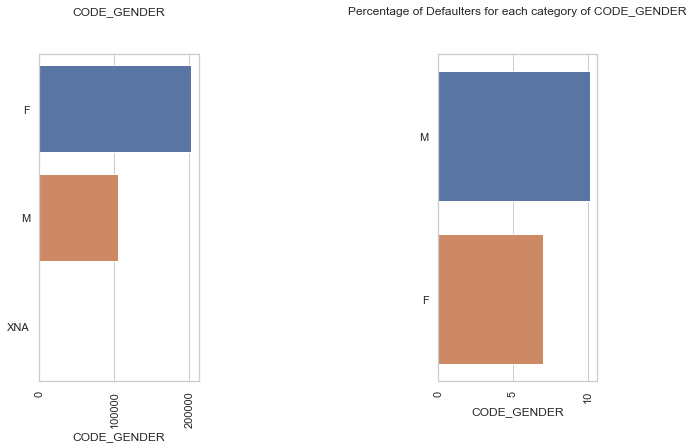

In [39]:
default_val_plotting(application_train,'CODE_GENDER')
plt.savefig('image/gender.png')

 * nous voyons qu'il y a plus de clientes qui ont demandé un prêt ce sont des femmes(202448) que de clients masculins(105059)
 * le pourcentage des clients pour chaque catégorie, on voit que ce sont les hommes (10.1%) qui ont tendance à avoir plus  que les femmes(7%)   
 * Il y a 4 lignes dans la table application_train avec le sexe "XNA", ce qui n'a aucun sens et peut être traité comme NaN.

### REGION_RATING_CLIENT_W_CITY

In [40]:
# Disribution de variable 'REGION_RATING_CLIENT_W_CITY' dans le dataset "application_train"
np.round(application_train['REGION_RATING_CLIENT_W_CITY'].value_counts(normalize=True)*100,1)

2    74.6
3    14.3
1    11.1
Name: REGION_RATING_CLIENT_W_CITY, dtype: float64

In [41]:
# Distribution de valeur 'REGION_RATING_CLIENT_W_CITY' parmi tous les clients défaillants
default_val(application_train,'REGION_RATING_CLIENT_W_CITY')


2  7.9 %
3  11.4 %
1  4.8 %


Total Number of categories of REGION_RATING_CLIENT_W_CITY = 3


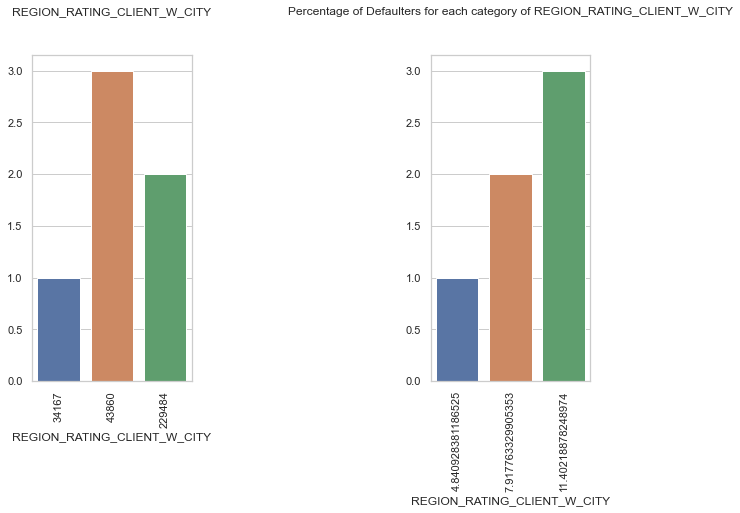

In [42]:
default_val_plotting(application_train,'REGION_RATING_CLIENT_W_CITY')
plt.savefig('image/region.png')

 * on constate que la majorité des personnes sont de la région avec une note de 2 (74,6%), et très peu de personnes sont des autres régions (14,3% et 11,1%).
 * cependant, si l'on regarde les caractéristiques des clients en difficultes , on voit que le pourcentage le plus élevé pour les clients de la région avec une note de 3 (11.4%), suivi de 2(7.9%) et 1(4.8%).   

### FLAG_EMP_PHONE

Cette colonne est une colonne booléenne, qui indique si le client a fourni son numéro de téléphone professionnel ou non.
Ici, 1 signifie Oui et 0 signifie Non.

In [43]:
# Disribution de variable 'FLAG_EMP_PHONE' dans le dataset "application_train"
np.round(application_train['FLAG_EMP_PHONE'].value_counts(normalize=True)*100,1)

1    82.0
0    18.0
Name: FLAG_EMP_PHONE, dtype: float64

In [44]:
# Distribution de valeur "FLAG_EMP_PHONE" parmi tous les clients défaillants 
default_val(application_train,'FLAG_EMP_PHONE')


1  8.7 %
0  5.4 %


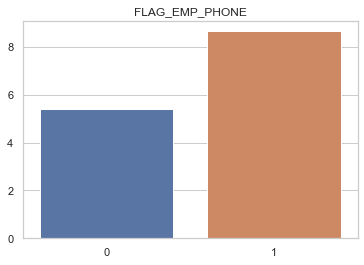

In [45]:
affichage(application_train,'FLAG_EMP_PHONE')
plt.savefig('image/tel_prof.png')

 * nous voyons que la gross majorité des candidats fournissent leur numéro de téléphone professionnel (82 %) et seulement 18 % n'ont pas fourni.
 * mais dans le nombre total de clients problématiques, ils sont quasiment les mêmes en termes de pourcentage

### NAME_EDUCATION_TYPE

In [46]:
application_train_EDUCAtION = application_train['NAME_EDUCATION_TYPE'].value_counts()
application_train_EDUCAtION

Secondary / secondary special    218391
Higher education                  74863
Incomplete higher                 10277
Lower secondary                    3816
Academic degree                     164
Name: NAME_EDUCATION_TYPE, dtype: int64

<AxesSubplot:>

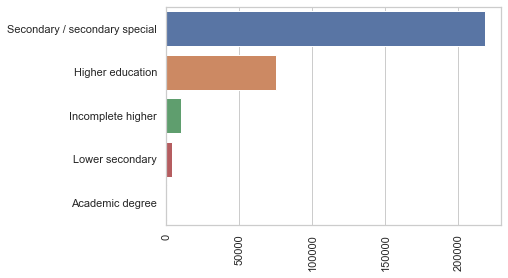

In [47]:
plt.figure(figsize=(6,4))
plt.xticks(rotation = 90)
sns.barplot(y=application_train_EDUCAtION.index, x = application_train_EDUCAtION.values, orient="h" )

In [48]:
# Distribution des valeurs NAME_EDUCATION_TYPE  parmi tous les clients défaillants 
default_val(application_train,'NAME_EDUCATION_TYPE')


Secondary / secondary special  8.9 %
Higher education  5.4 %
Incomplete higher  8.5 %
Lower secondary  10.9 %
Academic degree  1.8 %


Total Number of categories of NAME_EDUCATION_TYPE = 5


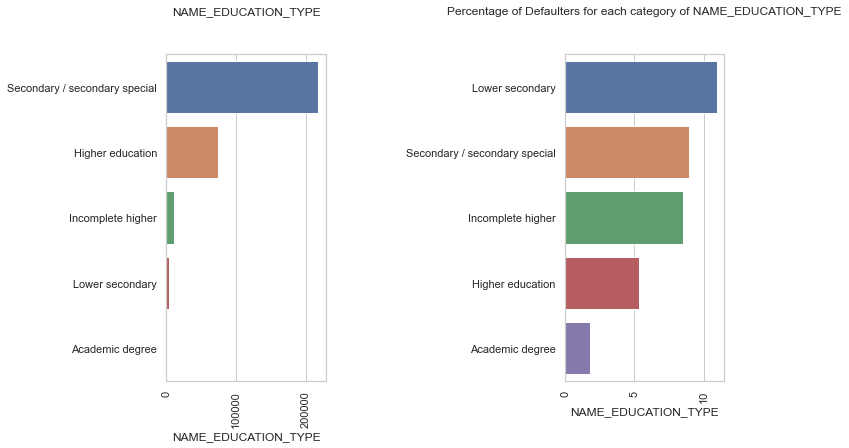

In [49]:
default_val_plotting(application_train,'NAME_EDUCATION_TYPE')
plt.savefig('image/education.png')

 * niveau d'études parmi tous les clients, on constate que la majorité des candidats n'ont étudié que jusqu'au secondaire/secondaire spécial, qui est suivi par l'enseignement supérieur.
 * parmi des clients défaillants, nous remarquons que le taux de default le plus élevé  pour les clients ayant fait leurs études uniquement jusqu'au premier cycle du secondaire.
 * visiblement  les candidats titulaires d'un diplôme universitaire ont le pourcentage le plus bas de défaillants.

### OCCUPATION_TYPE

Cette feature indique le type de profession du client. Cela peut être une caractéristique très importante qui peut décrire les caractéristiques par défaut du client

In [50]:
application_train_OCCUPATION = application_train['OCCUPATION_TYPE'].value_counts()
application_train_OCCUPATION

Laborers                 55186
Sales staff              32102
Core staff               27570
Managers                 21371
Drivers                  18603
High skill tech staff    11380
Accountants               9813
Medicine staff            8537
Security staff            6721
Cooking staff             5946
Cleaning staff            4653
Private service staff     2652
Low-skill Laborers        2093
Waiters/barmen staff      1348
Secretaries               1305
Realty agents              751
HR staff                   563
IT staff                   526
Name: OCCUPATION_TYPE, dtype: int64

Total Number of categories of OCCUPATION_TYPE = 19


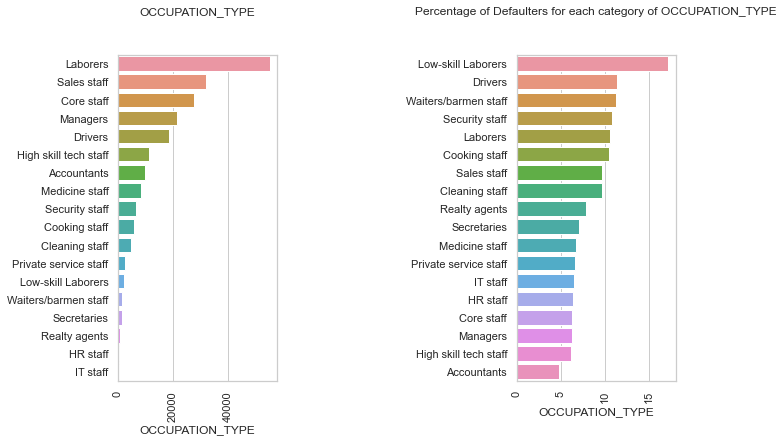

In [51]:
default_val_plotting(application_train,'OCCUPATION_TYPE')
plt.savefig('image/occupation.png')

 * la profession la plus courante parmi les candidats est celle des manœuvres, suivie du personnel de vente et du personnel de base.
 * si nous examinons la proportion de défaillants, nous observons que les personnes ayant des professions de bas niveau telles que les ouvriers peu qualifiés, les chauffeurs, les serveurs, etc. ont tendance à avoir un pourcentage de taux de défaut plus élevé que les professions de haut niveau.

### ORGANIZATION_TYPE

Comme le type d'occupation, le type d'organisation à laquelle appartient un client peut également être une caractéristique importante pour prédire le risque de défaut pour ce client.

Total Number of categories of ORGANIZATION_TYPE = 58


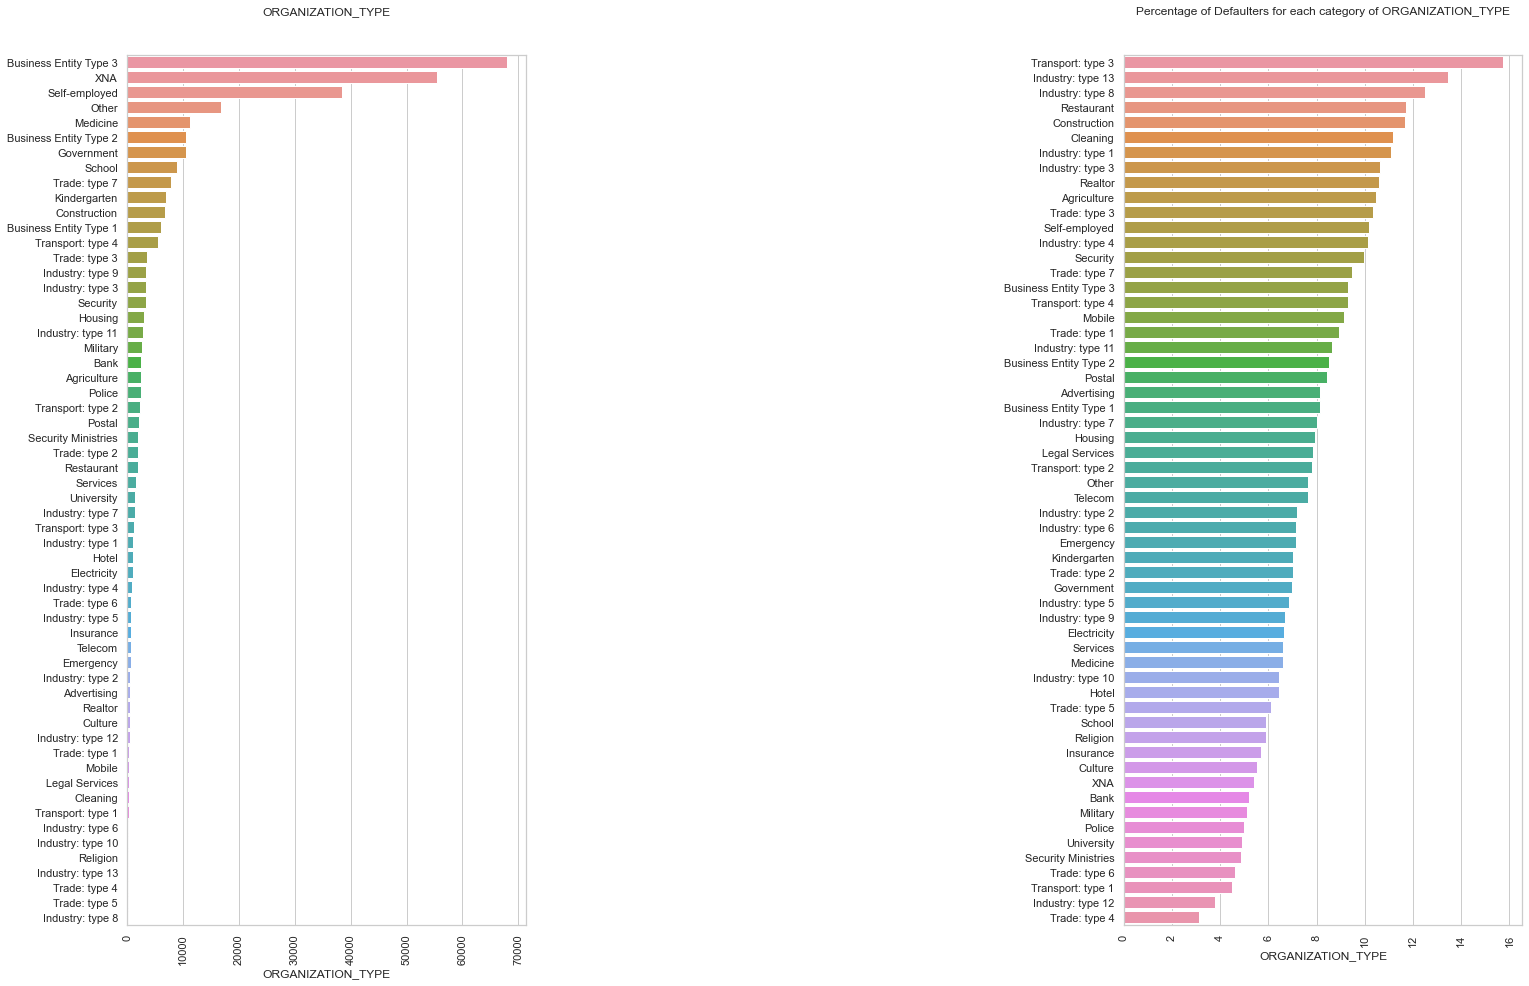

In [52]:
default_val_plotting(application_train,'ORGANIZATION_TYPE', (25,16))
plt.savefig('image/domain.png')

##### Il existe de nombreux types d'organisations auxquelles appartient un client
 * D'après le premier graphique, on peut voir que la majorité des candidats travaillent pour une organisation commerciale de type 3, XNA ou des organisations de travailleurs indépendants. Le type d'entité "XNA" est susceptible de désigner un type d'entité non classifié.
 * Dans le deuxième graphique, on peut voir que les demandeurs appartenant à la catégorie "Transport : Type 3" ont la plus forte propension à l'insolvabilité par rapport au reste. Ils sont suivis par des types d'organisation : "Industrie : Type 13", "Industrie : Type 8", "Restauration", "Construction", etc.
 * Les organisations qui affichent les scores par défaut les plus bas sont Commerce : Type 4, Industrie : Type 12, etc.

### REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY

REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY :
* indique si l'adresse permanente de la résidence du client correspond à son adresse de contact ou d'affaires au niveau régional.

LIVE_CITY_NOT_WORK_CITY:
* cette colonne indique si l'adresse de résidence permanente du client est la même que son adresse de contact au niveau de la ville ou non.

* 1 signifie que les adresses sont différentes et 0 signifie les mêmes adresses.

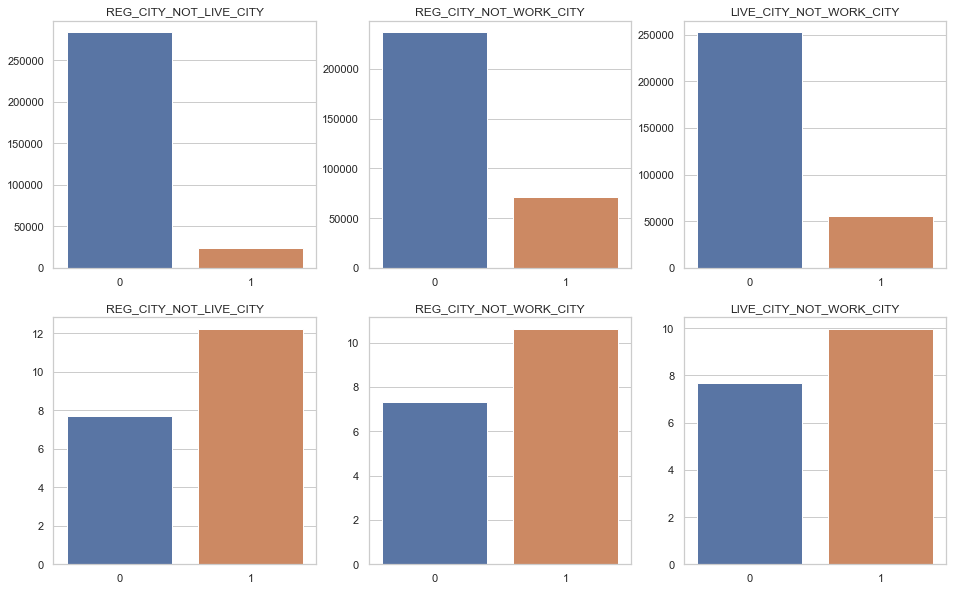

In [53]:
# Disribution de variable 'REG_CITY_NOT_LIVE_CITY, REG_CITY_NOT_WORK_CITY, LIVE_CITY_NOT_WORK_CITY' dans le dataset "application_train"
plt.figure(figsize=(16,10))
plt.subplot(2,3,1)
plt.title("REG_CITY_NOT_LIVE_CITY")
sns.barplot(x=application_train['REG_CITY_NOT_LIVE_CITY'].value_counts().index, y=application_train['REG_CITY_NOT_LIVE_CITY'].value_counts().values )
plt.subplot(2,3,2)
plt.title("REG_CITY_NOT_WORK_CITY")
sns.barplot(x=application_train['REG_CITY_NOT_WORK_CITY'].value_counts().index, y=application_train['REG_CITY_NOT_WORK_CITY'].value_counts().values )
plt.subplot(2,3,3)
plt.title("LIVE_CITY_NOT_WORK_CITY")
sns.barplot(x=application_train['LIVE_CITY_NOT_WORK_CITY'].value_counts().index, y=application_train['LIVE_CITY_NOT_WORK_CITY'].value_counts().values )
plt.subplot(2,3,4)
plt.title("REG_CITY_NOT_LIVE_CITY")
affichage(application_train,'REG_CITY_NOT_LIVE_CITY')
plt.subplot(2,3,5)
plt.title("REG_CITY_NOT_WORK_CITY")
affichage(application_train,'REG_CITY_NOT_WORK_CITY')
plt.subplot(2,3,6)
plt.title("LIVE_CITY_NOT_WORK_CITY")
affichage(application_train,'LIVE_CITY_NOT_WORK_CITY')


In [54]:
print("="*15);
print(application_train['REG_CITY_NOT_LIVE_CITY'].value_counts(normalize=True)*100);
print('-'*15);
default_val(application_train,'REG_CITY_NOT_LIVE_CITY');
print("="*15);
print('\n');
print("="*15);
print(application_train['REG_CITY_NOT_WORK_CITY'].value_counts(normalize=True)*100);
print('-'*15);
default_val(application_train,'REG_CITY_NOT_WORK_CITY');
print("="*15);
print('\n');
print("="*15);
print(application_train['LIVE_CITY_NOT_WORK_CITY'].value_counts(normalize=True)*100);
print('-'*15);
default_val(application_train,'LIVE_CITY_NOT_WORK_CITY');
print("="*15);

0    92.182719
1     7.817281
Name: REG_CITY_NOT_LIVE_CITY, dtype: float64
---------------
0  7.7 %
1  12.2 %


0    76.954646
1    23.045354
Name: REG_CITY_NOT_WORK_CITY, dtype: float64
---------------
0  7.3 %
1  10.6 %


0    82.044545
1    17.955455
Name: LIVE_CITY_NOT_WORK_CITY, dtype: float64
---------------
0  7.7 %
1  10.0 %


### Il n'y a qu'une minorité de candidats dont les adresses ne correspondent pas
 * seulement 7,52% des personnes ont une adresse permanente autre qu'un contact régional
 * il y a environ 23,05 % de personnes dont l'adresse permanente diffère de leur adresse professionnelle au niveau régional
 * environ 17,96 % des personnes ont une adresse permanente différente de leur adresse de contact au niveau de la ville
 * la propension à faire défaut est plus élevée pour les personnes ayant des adresses différentes que pour les personnes ayant la même adresse

In [55]:
# garbage collection
import gc   
gc.collect()

42449

### FLAG_DOCUMENT_3

Le client a-t-il fourni le document 3

In [56]:
print("="*15);
print(application_train['FLAG_DOCUMENT_3'].value_counts(normalize=True)*100);
print('-'*15);
default_val(application_train,'FLAG_DOCUMENT_3');
print("="*15);


1    71.002338
0    28.997662
Name: FLAG_DOCUMENT_3, dtype: float64
---------------
1  8.8 %
0  6.2 %


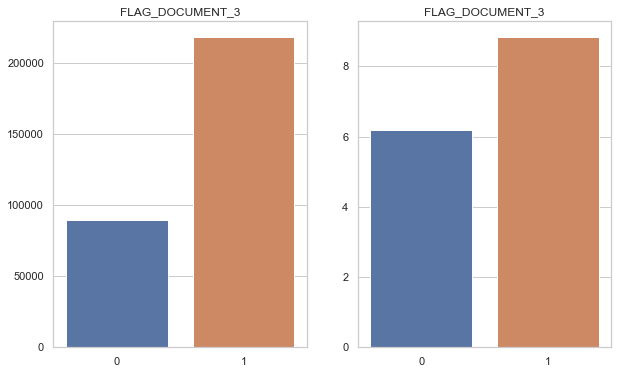

In [57]:
# Disribution de variable 'FLAG_DOCUMENT_3' dans le dataset "application_train"
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.title("FLAG_DOCUMENT_3")
sns.barplot(x=application_train['FLAG_DOCUMENT_3'].value_counts().index, y=application_train['FLAG_DOCUMENT_3'].value_counts().values )
plt.subplot(1,2,2)
plt.title("FLAG_DOCUMENT_3_")
affichage(application_train,'FLAG_DOCUMENT_3')
plt.savefig('image/doc 3.png')

 * on voit que la majorité des clients n'ont pas fourni ce document (~71%) et seulement 29% l'ont fait.
 * on voit que ceux qui ont fourni ce document avaient un taux de non-paiement plus élevé que ceux qui ne l'ont pas fait. Cela signifie que les candidats qui ont soumis Document_3 sont plus susceptibles d'être en défaut que ceux qui ne l'ont pas fait.
 * on ne peut rien dire sur le document 3

# Les variables numérique 

In [58]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
 
    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

### Répartition de l\'âge  du demandeur

Les features "DAYS" sont exprimées en jours négatifs , on va les transformer en années, ce qui sera plus facile à analyser et à interpréter

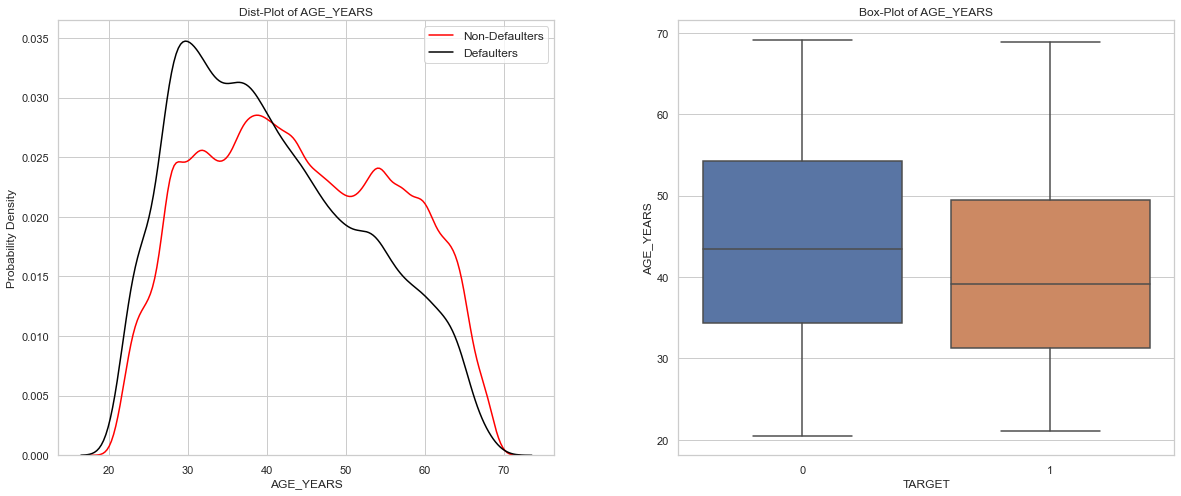

<Figure size 432x288 with 0 Axes>

In [59]:
application_train['AGE_YEARS'] = application_train['DAYS_BIRTH'] * -1 / 365
plot_continuous_variables(application_train, 'AGE_YEARS', plots = ['distplot','box'])
application_train.drop(columns='AGE_YEARS', inplace=True)
plt.savefig('image/years.png')

  * on voit que le pic d'âge des personnes qui ont difficultés sont proches de 30 ans et  l'age for Defaulters commence un peu à gauche des Non-Defaulters (cela signifie que les défaillants sont généralement plus jeunes que les non-défaillants)
  * la valeur de 0,75 percentile pour les non-defaillants est d'environ 54 ans et pour les défaillants, elle est d'environ 49 ans.

### DAYS_EMPLOYED

In [60]:
# La statistique générale pour la colonne "DAYS_EMPLOYED"
application_train['YEARS_EMPLOYED'] = application_train.DAYS_EMPLOYED * -1 / 365
application_train.YEARS_EMPLOYED.describe()


count    307511.000000
mean       -174.835742
std         387.056895
min       -1000.665753
25%           0.791781
50%           3.323288
75%           7.561644
max          49.073973
Name: YEARS_EMPLOYED, dtype: float64

* trop de differance entre les valeurs "médian" et "moyen"

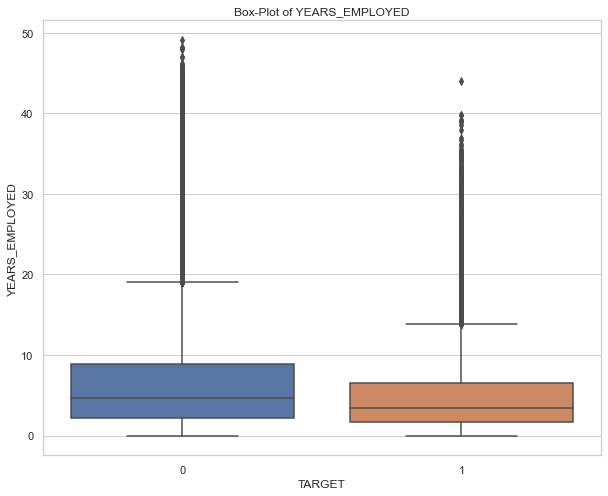

In [61]:
plot_continuous_variables(application_train, 'YEARS_EMPLOYED', plots = ['box'], scale_limits = [0,70], figsize = (10,8))


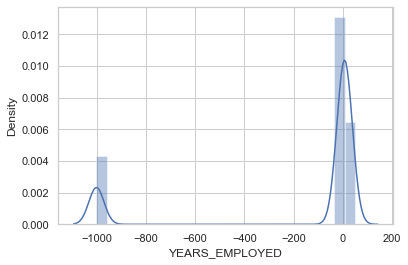

In [62]:
# La distribution du variable
sns.distplot(application_train['YEARS_EMPLOYED'], bins=25, kde = "his" )
plt.savefig('image/years employed.png')

In [63]:
# Possible que la valeur -1000.67 correspond au clients qui ne travaillent plus(retraités)
print(application_train['YEARS_EMPLOYED'].value_counts().sort_index(ascending = True).head())
print("="*25)
print('\n')
print("Statistique des clients pour lesquels a été noté  une valeur égale à -1000 ")
application_train[application_train['YEARS_EMPLOYED'] <0]['YEARS_EMPLOYED'].describe()

-1000.665753    55374
 0.000000           2
 0.002740           1
 0.005479           2
 0.008219           3
Name: YEARS_EMPLOYED, dtype: int64


Statistique des clients pour lesquels a été noté  une valeur égale à -1000 


count    5.537400e+04
mean    -1.000666e+03
std      3.840376e-10
min     -1.000666e+03
25%     -1.000666e+03
50%     -1.000666e+03
75%     -1.000666e+03
max     -1.000666e+03
Name: YEARS_EMPLOYED, dtype: float64

In [64]:
# On va diviser la colonne en 2 parties (retraités et non_retraités)
data_non_r = application_train[application_train['YEARS_EMPLOYED']>=0.0]
data_r = application_train[application_train['YEARS_EMPLOYED'] <0 ]

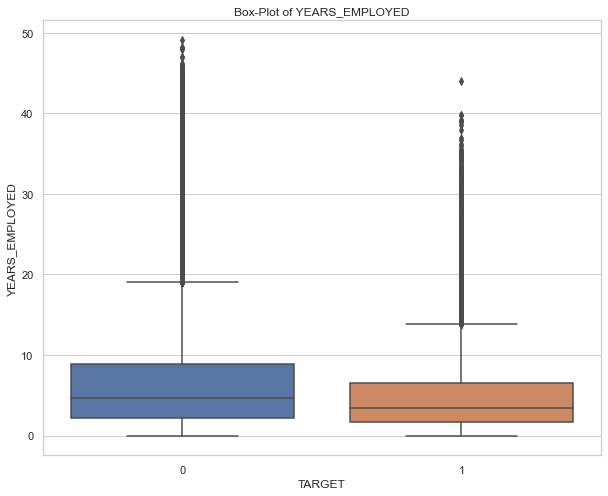

In [65]:
plot_continuous_variables(data_non_r, 'YEARS_EMPLOYED', plots = ['box'], scale_limits = [0,70], figsize = (10,8))


In [66]:
# La stat général 
data_non_r.groupby(['TARGET'])['YEARS_EMPLOYED'].describe(percentiles=[0.25,0.5,0.75,0.9,0.92,0.94,0.96,0.98])

,count,mean,std,min,25%,50%,75%,90%,92%,94%,96%,98%,max
TARGET,,,,,,,,,,,,,
0,230302.0,6.679836,6.499752,0.0,2.161644,4.632877,8.915068,14.830137,16.580822,18.997260,21.939726,27.090411,49.073973
1,21835.0,4.972380,5.067783,0.0,1.627397,3.369863,6.521918,10.978630,12.303671,13.986192,16.387068,21.352438,44.024658


 * Les défaillants semblent avoir moins d'années d'emploi que les non-défaillants. Tous les 25e, 50e et 75e quantiles des Défaillants sont inférieurs à ceux des Non-Défaillants.

In [67]:
# Nous verrons la capacité des retraités (selon notre hypothèse) à rembourser leurs emprunts
data_r['TARGET'].value_counts()/data_r.shape[0]*100

0    94.600354
1     5.399646
Name: TARGET, dtype: float64

In [68]:
application_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 123 entries, SK_ID_CURR to YEARS_EMPLOYED
dtypes: float16(61), float32(4), float64(1), int16(2), int32(2), int8(37), object(16)
memory usage: 94.7+ MB


 * seulement 5.4 % des clients ont difficulté de remboursement parmi ces clients

In [69]:
application_train.drop(columns=["YEARS_EMPLOYED"], inplace=True)

In [70]:
# garbage collection
import gc   
gc.collect()

22862

### DAYS_ID_PUBLISH

* changement de la pièce d'identité avec laquelle le client a demandé un prêt

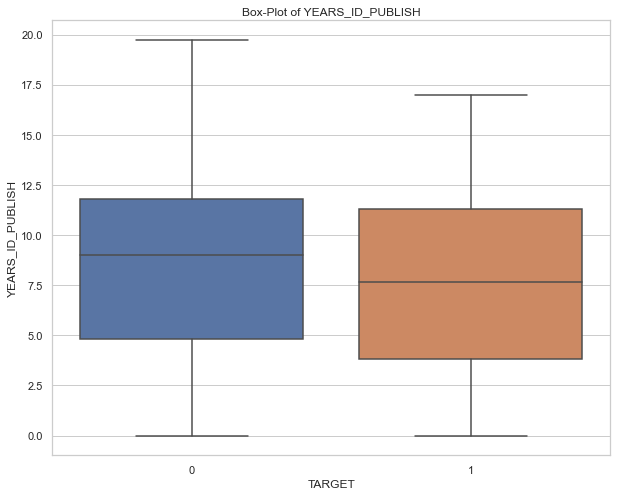

In [71]:
application_train["YEARS_ID_PUBLISH"] = application_train["DAYS_ID_PUBLISH"] * -1 / 365
plot_continuous_variables(application_train, 'YEARS_ID_PUBLISH', plots = ['box'], figsize = (10,8))

 * à partir de la boîte à moustaches ci-dessus, les défaillants avaient généralement moins de jours depuis qu'ils avaient changé d'identité. 
 * les non-défaillants montrent un plus grand nombre de jours pour tous les quantiles depuis qu'ils ont changé de pièce d'identité

In [72]:
application_train.drop(columns=["YEARS_ID_PUBLISH"], inplace=True)

### EXT_SOURCES

Il y a trois colonnes EXT_SOURCES, qui contiennent des valeurs comprises entre 0 et 1. Ce sont des scores normalisés provenant de différentes sources

----------------------------------------------------------------------------------------------------


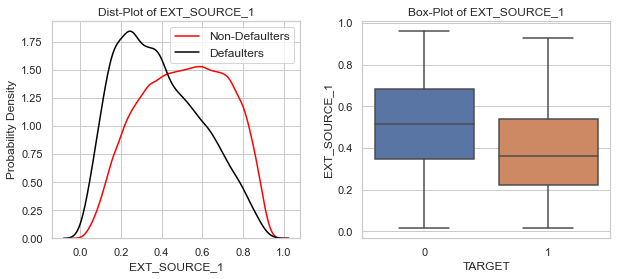

----------------------------------------------------------------------------------------------------


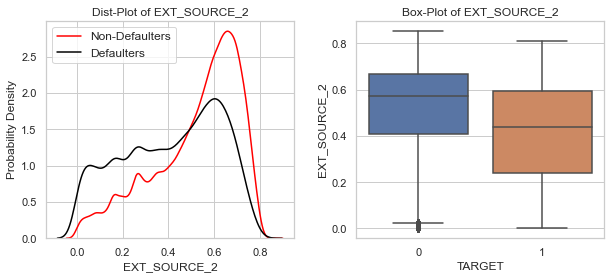

----------------------------------------------------------------------------------------------------


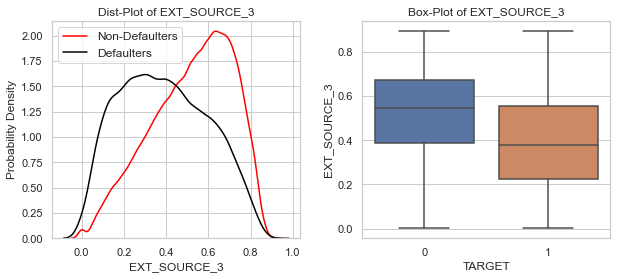

----------------------------------------------------------------------------------------------------


<Figure size 432x288 with 0 Axes>

In [73]:
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_1', plots = ['distplot', 'box'], figsize = (10,4))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_2', plots = ['distplot', 'box'], figsize = (10,4))
print('-'*100)
plot_continuous_variables(application_train, 'EXT_SOURCE_3', plots = ['distplot', 'box'], figsize = (10,4))
print('-'*100)
plt.savefig('image/source 123.png')

### Il y a une tendance similaire pour les trois colonnes EXT_SOURCE:
 * les Defaulters ont tendance à avoir des valeurs considérablement plus faibles.
 * les non-défaillants présentent un pic plus élevé à des valeurs EXT_SOURCE élevées, et les densités de probabilité sont très faibles pour des valeurs faibles. Cela implique que les non-défaillants ont généralement des valeurs élevées de ces scores.
 * la valeur médiane des défaillants est presque égale ou inférieure aux valeurs du 25e centile des non-défaillants.
 * les colonnes EXT_SOURCE_1 et EXT_SOURCE_3 ont tendance à afficher une meilleure discrimination/séparabilité par rapport à EXT_SOURCE_2.
 * ces 3 fonctionnalités semblent être les meilleures pour séparer linéairement les défaillants et les non-défaillants parmi toutes les fonctionnalités jusqu'à présent.

### FLOORSMAX_AVG and FLOORSMIN_MODE

Ces colonnes décrivent les scores normalisés "FLOORS MAX_AVG" et "FLOORSMIN_MODE" concernant aux étages des bâtiments.

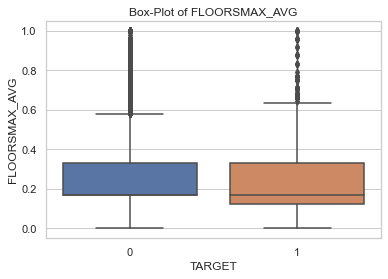

In [74]:
plot_continuous_variables(application_train, 'FLOORSMAX_AVG', plots = ['box'], figsize = (6,4))

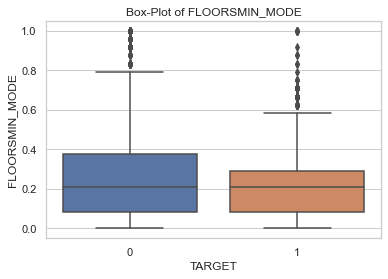

In [75]:
plot_continuous_variables(application_train, 'FLOORSMIN_MODE', plots = ['box'], figsize = (6,4))

 * les défaillants ont une valeur médiane inférieure de la caractéristique FLOORSMAX_AVG par rapport aux non-défaillants. 
 * les valeurs du 75- percentile pour les défaillants et les non-défaillants sont plus ou moins les mêmes, mais la valeur du 25- percentile pour les non-défaillants est presque supérieure à la médiane pour les défaillants, cela peut donc être une caractéristique importante.
 * les non-défaillants ont également tendance à afficher une valeur FLLORSMIN_MODE plus élevée que les non-défaillants. La valeur du 75- percentile des non-défaillants est nettement supérieure à la valeur du 75-percentile des non-défaillants.

In [76]:
# garbage collection
import gc   
gc.collect()

30064

# 

# bureau.csv

#### Ce tableau comprend tous les dossiers de crédit anférieurs des clients auprès d'institutions financières autres que Home Credit Group qui ont été déclarés par le bureau de crédit.

In [77]:
# La stat générale 
print(f'La dimension du bureau.csv: {bureau.shape}')
print('-'*100)
print(f'Le nombre de SK_ID_BUREAU uniques: {len(bureau.SK_ID_BUREAU.unique())}')
print(f'Le nombre de SK_ID_CURR uniques: {len(bureau.SK_ID_CURR.unique())}')
print(f'Le nombre de SK_ID_CURR qui sont communs dans application_train.csv et bureau.csv: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print(f'Le nombre de SK_ID_CURR qui sont communs dans application_test.csv et bureau.csv: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(bureau.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Le nombre de doublons valeurs en bureau: {bureau.shape[0] - bureau.duplicated().shape[0]}')
print('-'*100)
display(bureau.head(5))

La dimension du bureau.csv: (1716428, 17)
----------------------------------------------------------------------------------------------------
Le nombre de SK_ID_BUREAU uniques: 1716428
Le nombre de SK_ID_CURR uniques: 305811
Le nombre de SK_ID_CURR qui sont communs dans application_train.csv et bureau.csv: 263491
Le nombre de SK_ID_CURR qui sont communs dans application_test.csv et bureau.csv: 42320
----------------------------------------------------------------------------------------------------
Le nombre de doublons valeurs en bureau: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


Number of Variables include Missing Values: 7 



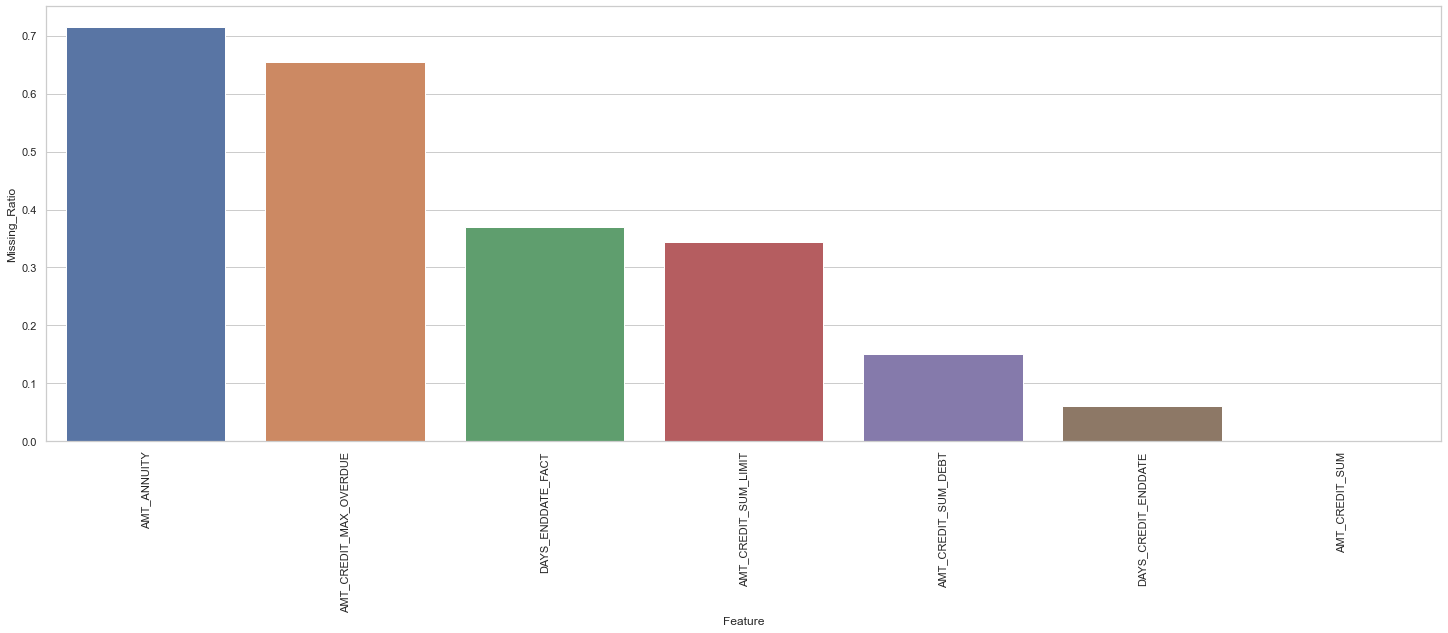

                  Feature  Num_Missing  Missing_Ratio DataTypes
0             AMT_ANNUITY      1226791       0.714735   float32
1  AMT_CREDIT_MAX_OVERDUE      1124488       0.655133   float32
2       DAYS_ENDDATE_FACT       633653       0.369170   float16
3    AMT_CREDIT_SUM_LIMIT       591780       0.344774   float32
4     AMT_CREDIT_SUM_DEBT       257669       0.150119   float32
5     DAYS_CREDIT_ENDDATE       105553       0.061496   float16
6          AMT_CREDIT_SUM           13       0.000008   float32 



In [78]:
# Les valeurs NaN
missing_values(bureau, plot=True)

 *  7/17 -  contiennent des valeurs NaN.
 * les valeurs NaN les plus élevées (1226791) sont dans la colonne AMT_ANNUITY qui a plus de 70% de valeurs manquantes.

#### Merging des TARGETS de application_train avec la table bureau.

In [79]:
bureau_merged = application_train.iloc[:,:2].merge(bureau, on = 'SK_ID_CURR', how = 'left')


Phi-K Matrix

----------------------------------------------------------------------------------------------------


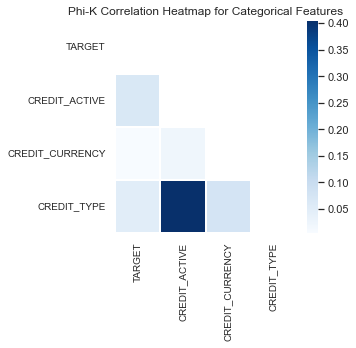

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
0,CREDIT_ACTIVE,0.064481
2,CREDIT_TYPE,0.049954
1,CREDIT_CURRENCY,0.004993


----------------------------------------------------------------------------------------------------


In [80]:
cols_for_phik = ['TARGET','CREDIT_ACTIVE','CREDIT_CURRENCY','CREDIT_TYPE']
plot_phik_matrix(bureau_merged, cols_for_phik,  figsize = (5,5))

* la variable CREDIT_TYPE montre une certaine association avec la variable CREDIT_ACTIVE.
* les variables catégorielles n'ont pas vraiment une forte association avec la variable TARGET, en particulier la fonctionnalité CREDIT_CURRENCY.

----------------------------------------------------------------------------------------------------


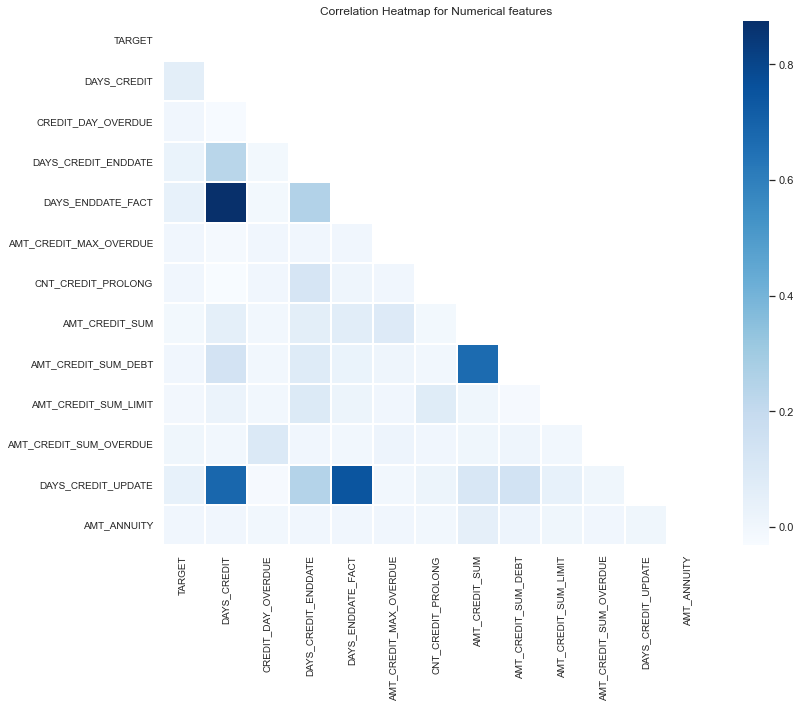

----------------------------------------------------------------------------------------------------


In [81]:
# Matrice de corrélation des variables 
corr_mat = correlation_matrix(bureau_merged, ['SK_ID_CURR','SK_ID_BUREAU'], cmap = 'Blues', figsize = (12,10))
corr_mat.plot_correlation_matrix()

### CREDIT_ACTIVE

In [82]:
# Les valeurs de la colonne
print("Les valeurs de la colonne")
print(bureau_merged['CREDIT_ACTIVE'].unique())
print('-'*35)
bureau_merged['CREDIT_ACTIVE'].value_counts(normalize=True)*100

Les valeurs de la colonne
['Closed' 'Active' nan 'Sold' 'Bad debt']
-----------------------------------


Closed      62.629997
Active      36.982854
Sold         0.385785
Bad debt     0.001365
Name: CREDIT_ACTIVE, dtype: float64

In [83]:
# le pourcentage des valeurs de la colonne des clients défaillants
default_val(bureau_merged,'CREDIT_ACTIVE')

Closed  6.9 %
Active  9.3 %
Sold  10.1 %
Bad debt  20.0 %


Total Number of categories of CREDIT_ACTIVE = 5


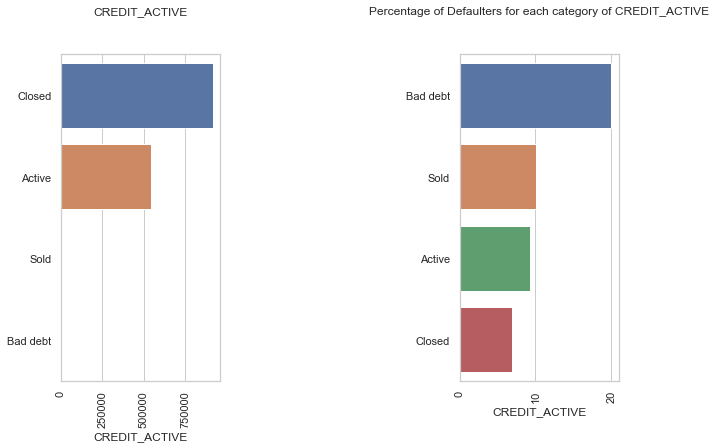

In [84]:
# Affichage
default_val_plotting(bureau_merged,'CREDIT_ACTIVE')
plt.savefig('image/credit active.png')

* d'après le premier sous-graphique, nous pouvons voir que la majorité des prêts antérieurs des autres institutions financières sont des prêts fermés (62,63%), suivis de 36,98% des prêts actifs
* sur le deuxième graphique, le pourcentage de non-payeurs par catégorie est environ 20% , ce qui est le taux de non-paiement le plus élevé    

### DAYS_CREDIT

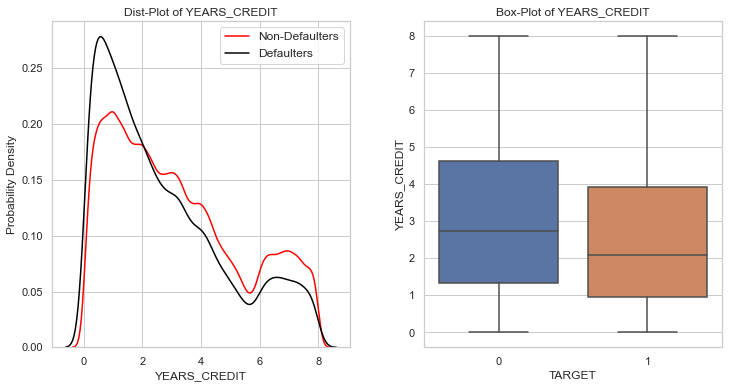

In [85]:
bureau_merged['YEARS_CREDIT'] = bureau_merged['DAYS_CREDIT']* -1 / 365
plot_continuous_variables(bureau_merged, 'YEARS_CREDIT', plots = ['distplot', 'box'], figsize = (12,6))
bureau_merged.drop(columns=['YEARS_CREDIT'], inplace= True)


 * les défaillants ont tendance à avoir des pics plus élevés que les non-défaillants pour les demandes de prêt relativement récentes. 
 * la courbe des non-payeurs est également légèrement décalée vers la gauche par rapport aux non-payeurs.
 * on voit aussi que les non-payeurs avaient généralement moins de YEARS_CREDIT que les non-payeurs.

### DAYS_CREDIT_ENDDATE

In [86]:
# La stat général 
bureau_merged.groupby(['TARGET'])['DAYS_CREDIT_ENDDATE'].describe(percentiles=[0.12,0.16,0.2,0.25,0.5,0.75])

,count,mean,std,min,12%,16%,20%,25%,50%,75%,max
TARGET,,,,,,,,,,,
0,1271015.0,NaN,NaN,-42048.0,-1812.0,-1581.0,-1383.0,-1162.0,-353.0,446.0,31200.0
1,105212.0,NaN,NaN,-42048.0,-1577.0,-1334.0,-1127.0,-910.0,-120.0,735.0,31200.0


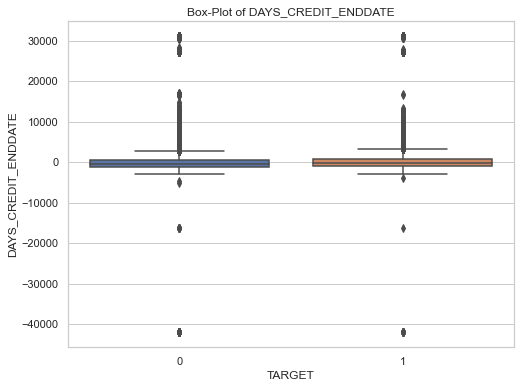

----------------------------------------------------------------------------------------------------


In [87]:
plot_continuous_variables(bureau_merged, 'DAYS_CREDIT_ENDDATE', plots = ['box'], figsize = (8,6))
print('-'*100)

DAYS_CREDIT_ENDDATE semble être erronée. La valeur 'min' remonte à 42060 jours(115 ans). Cela n'a pas beaucoup de sens car cela implique que le prêt précédent du client remonte à 115 ans. Il pourrait également s'agir d'un prêt hérité, mais nous ne pouvons pas en parler avec certitude. Nous essaierons de supprimer ces valeurs dans l'étape de prétraitement des données.

### DAYS_ENDDATE_FACT

Cette colonne indique le nombre de jours écoulés depuis que le crédit du 'Credit Bureau'  s'est terminé au moment de la demande de nouveau  crédit immobilier. Ces valeurs ne concernent que les crédits fermés.

In [88]:
# La stat général 
bureau_merged.groupby(['TARGET'])['DAYS_ENDDATE_FACT'].describe(percentiles=[0.12,0.16,0.2,0.25,0.5,0.75])

,count,mean,std,min,12%,16%,20%,25%,50%,75%,max
TARGET,,,,,,,,,,,
0,856756.0,NaN,NaN,-42016.0,-2088.0,-1898.0,-1708.0,-1514.0,-908.0,-434.0,0.0
1,63896.0,-inf,inf,-2916.0,-1943.0,-1707.0,-1530.0,-1335.0,-767.0,-345.0,0.0


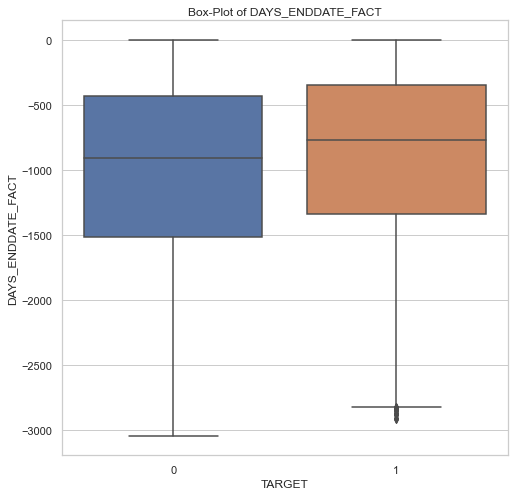

----------------------------------------------------------------------------------------------------


In [89]:
plot_continuous_variables(bureau_merged, 'DAYS_ENDDATE_FACT', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 0])
print('-'*100)

 * on voit que les défaillants ont tendance à avoir moins de jours à compter de la fin de leur prêt avec les bureaux de crédit. 
 * les prêts anférieurs des non-défaillants se terminent généralement plus tôt que ceux des défaillants

In [90]:
# garbage collection
import gc   
gc.collect()

34108

### YEARS_CREDIT_UPDATE

Cette colonne indique le nombre de jours depuis lesquels les informations du bureau de crédit ont été reçues au moment de la demande de prêt avec Home Credit.

In [91]:
# La stat général 
bureau_merged['YEARS_CREDIT_UPDATE'] = bureau_merged['DAYS_CREDIT_UPDATE']* -1/365
bureau_merged.groupby(['TARGET'])['YEARS_CREDIT_UPDATE'].describe(percentiles=[0.12,0.16,0.2,0.25,0.5,0.75])

,count,mean,std,min,12%,16%,20%,25%,50%,75%,max
TARGET,,,,,,,,,,,
0,1350805.0,1.667405,2.013851,-1.019178,0.041096,0.054795,0.071233,0.095890,1.153425,2.504110,114.923288
1,114520.0,1.358359,2.063197,-0.060274,0.032877,0.043836,0.052055,0.065753,0.627397,2.093151,114.884932


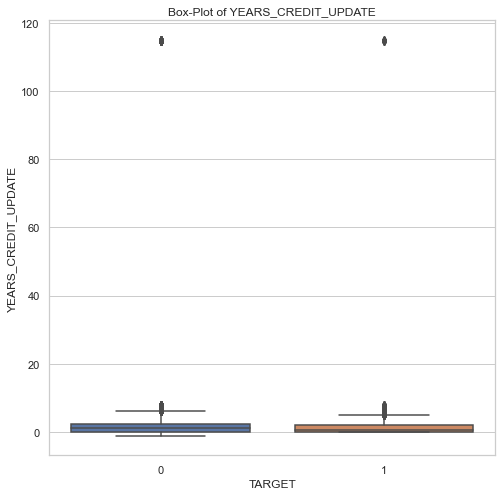

----------------------------------------------------------------------------------------------------


In [92]:
plot_continuous_variables(bureau_merged, 'YEARS_CREDIT_UPDATE', plots = ['box'], figsize = (8,8), scale_limits = [-40000, 400])
print('-'*100)
bureau_merged.drop(columns=['YEARS_CREDIT_UPDATE'], inplace= True)

 *  nous pouvons dire que les défaillants ont tendance à avoir moins de jours après avoir reçu des informations sur le bureau de crédit. 
 * leurs valeurs médianes du 75-percentile sont inférieures à celles des non-défaillants

# bureau_balance

Ce tableau se compose du solde mensuel de chaque prêt pour chacun des prêts anférieurs que le client avait auprès d'institutions financières autres que Home Credit.

In [93]:
# La stat générale 
print(f'la dimension du dataset: {bureau_balance.shape}')
print('-'*100)
print(f'Le nombre de doublons : {bureau_balance.shape[0] - bureau_balance.duplicated().shape[0]}')
print('-'*100)
print(f'Le nombre d\'unique SK_ID_BUREAU : {len(bureau_balance.SK_ID_BUREAU.unique())}')
print('-'*100)
print(f'Le nombre d\'unique valeurs dans la colonne STATUS: {len(bureau_balance.STATUS.unique())}')
print(f"Le nombre d\'unique valeurs:\n{bureau_balance.STATUS.unique()}")
print("C -  signifie fermé, X -  signifie statut inconnu, 0 -  signifie pas de DPD\n","1 -  signifie maximum fait pendant le mois entre 1-30, 2  - signifie DPD 31-60\n","… 5 signifie DPD 120+ ou vendu ou radié")
print('-'*100)
print(f"Le nombre maximale de mois dans la colonne Months Balance: {np.abs(bureau_balance.MONTHS_BALANCE.min())}")
print('-'*100)
display(bureau_balance.sample(5))

la dimension du dataset: (27299925, 3)
----------------------------------------------------------------------------------------------------
Le nombre de doublons : 0
----------------------------------------------------------------------------------------------------
Le nombre d'unique SK_ID_BUREAU : 817395
----------------------------------------------------------------------------------------------------
Le nombre d'unique valeurs dans la colonne STATUS: 8
Le nombre d'unique valeurs:
['C' '0' 'X' '1' '2' '3' '5' '4']
C -  signifie fermé, X -  signifie statut inconnu, 0 -  signifie pas de DPD
 1 -  signifie maximum fait pendant le mois entre 1-30, 2  - signifie DPD 31-60
 … 5 signifie DPD 120+ ou vendu ou radié
----------------------------------------------------------------------------------------------------
Le nombre maximale de mois dans la colonne Months Balance: 96
----------------------------------------------------------------------------------------------------


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
16764149,5889027,-7,C
26792763,5400723,-32,X
26557242,5988873,-36,0
15520591,6389085,-4,0
27052748,5355535,-4,X


 * Le solde du mois le plus ancien que nous ayons est le statut de 96 mois, c'est-à-dire que le statut a été fourni jusqu'à 8 ans d'historique pour les prêts pour lesquels ceux-ci existent.

In [94]:
# Les valeurs NaN
missing_values(bureau_balance, plot=False)

Number of Variables include Missing Values: 0 

Empty DataFrame
Columns: [Feature, Num_Missing, Missing_Ratio, DataTypes]
Index: [] 



# 

# previous_application.csv

Ce tableau contient les données statistiques du prêt précédent que le client avait demandé à Home Credit.

In [95]:
# La stat générale 
print(f'La dimension du dataset: {previous_application.shape}')
print('-'*100)
print(f'Le nombre d\'unique SK_ID_PREV : {len(previous_application.SK_ID_PREV.unique())}')
print(f'Le nombre d\'unique SK_ID_CURR : {len(previous_application.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Les nombres communs SK_ID_CURR dans application_train.csv et previous_application.csv: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print(f'Les nombres communs SK_ID_CURR dans application_test.csv et previous_application.csv: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(previous_application.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Le nombre des valeurs doublons : {previous_application.shape[0] - previous_application.duplicated().shape[0]}')
print('-'*100)
display(previous_application.head())

La dimension du dataset: (1670214, 37)
----------------------------------------------------------------------------------------------------
Le nombre d'unique SK_ID_PREV : 1670214
Le nombre d'unique SK_ID_CURR : 338857
----------------------------------------------------------------------------------------------------
Les nombres communs SK_ID_CURR dans application_train.csv et previous_application.csv: 291057
Les nombres communs SK_ID_CURR dans application_test.csv et previous_application.csv: 47800
----------------------------------------------------------------------------------------------------
Le nombre des valeurs doublons : 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182861,0.867188,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


Number of Variables include Missing Values: 16 



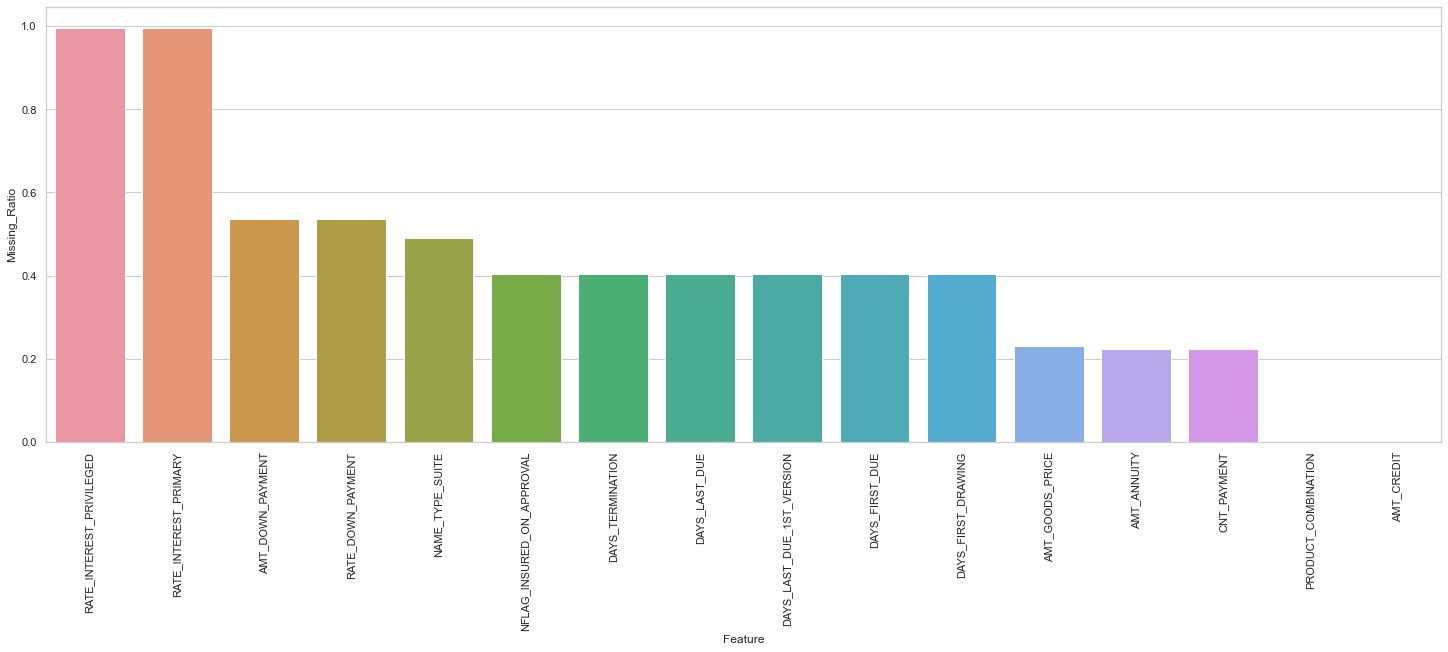

                      Feature  Num_Missing  Missing_Ratio DataTypes
0    RATE_INTEREST_PRIVILEGED      1664263   9.964370e-01   float16
1       RATE_INTEREST_PRIMARY      1664263   9.964370e-01   float16
2            AMT_DOWN_PAYMENT       895844   5.363648e-01   float32
3           RATE_DOWN_PAYMENT       895844   5.363648e-01   float16
4             NAME_TYPE_SUITE       820405   4.911975e-01    object
5   NFLAG_INSURED_ON_APPROVAL       673065   4.029813e-01   float16
6            DAYS_TERMINATION       673065   4.029813e-01   float32
7               DAYS_LAST_DUE       673065   4.029813e-01   float32
8   DAYS_LAST_DUE_1ST_VERSION       673065   4.029813e-01   float32
9              DAYS_FIRST_DUE       673065   4.029813e-01   float32
10         DAYS_FIRST_DRAWING       673065   4.029813e-01   float32
11            AMT_GOODS_PRICE       385515   2.308177e-01   float32
12                AMT_ANNUITY       372235   2.228667e-01   float32
13                CNT_PAYMENT       372230   2.2

In [96]:
# Les valeurs NaN
missing_values(previous_application, plot=True)

##### Sur les 37 colonnes, 16 contiennent des valeurs NaN
 * deux  colonnes ont 99,64 % de valeurs manquantes
 * sauf de ces deux colonnes, le reste des colonnes contient également> 40% de valeurs NaN  

In [97]:
# On va fusionner le cible 'TARGET' des datasets  application_train et previous_application
prev_merged = application_train.iloc[:,:2].merge(previous_application, on = 'SK_ID_CURR', how = 'left')

----------------------------------------------------------------------------------------------------


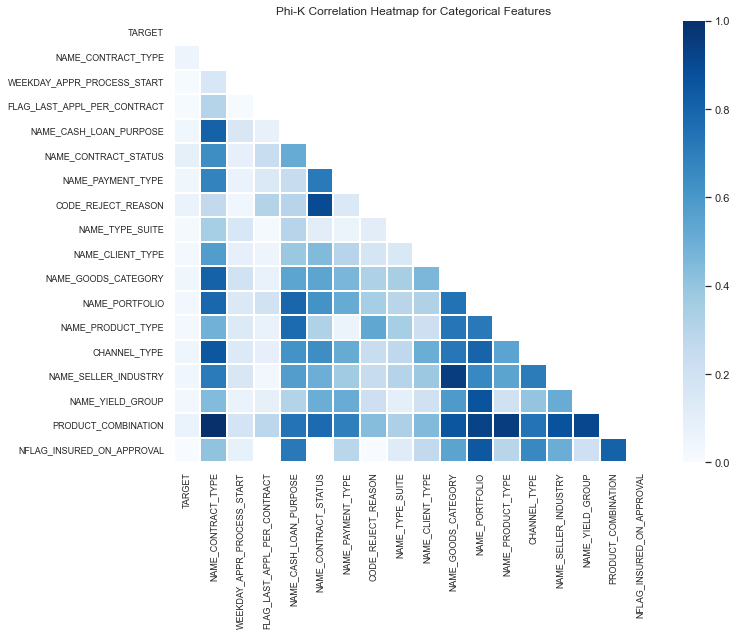

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
4,NAME_CONTRACT_STATUS,0.088266
15,PRODUCT_COMBINATION,0.063839
6,CODE_REJECT_REASON,0.062771
0,NAME_CONTRACT_TYPE,0.050859
12,CHANNEL_TYPE,0.050302
9,NAME_GOODS_CATEGORY,0.042951
3,NAME_CASH_LOAN_PURPOSE,0.040305
5,NAME_PAYMENT_TYPE,0.039752
13,NAME_SELLER_INDUSTRY,0.038077
14,NAME_YIELD_GROUP,0.034626


----------------------------------------------------------------------------------------------------


In [98]:
# Phi-K Matrix
cols_for_phik = ['TARGET'] + prev_merged.dtypes[prev_merged.dtypes == 'object'].index.tolist() + ['NFLAG_INSURED_ON_APPROVAL']
plot_phik_matrix(prev_merged, cols_for_phik, cmap = 'Blues', figsize = (11,9), fontsize = 9)

 * le variable PRODUCT_COMBINATION montre la corrélation avec de nombreuses autres features telles que NAME_CONTRACT_TYPE, NAME_PRODUCT_TYPE, NAME_PORTFOLIO, etc.
 * le variable NAME_GOODS_CATEGORY est également étroitement liée à NAME_SELLER_INDUSTRY.
 * les variables NAME_CONTRACT_STATUS, PRODUCT_COMBINATION, CODE_REJECT_REASON sont parmi les features corrélés les plus élevées

----------------------------------------------------------------------------------------------------


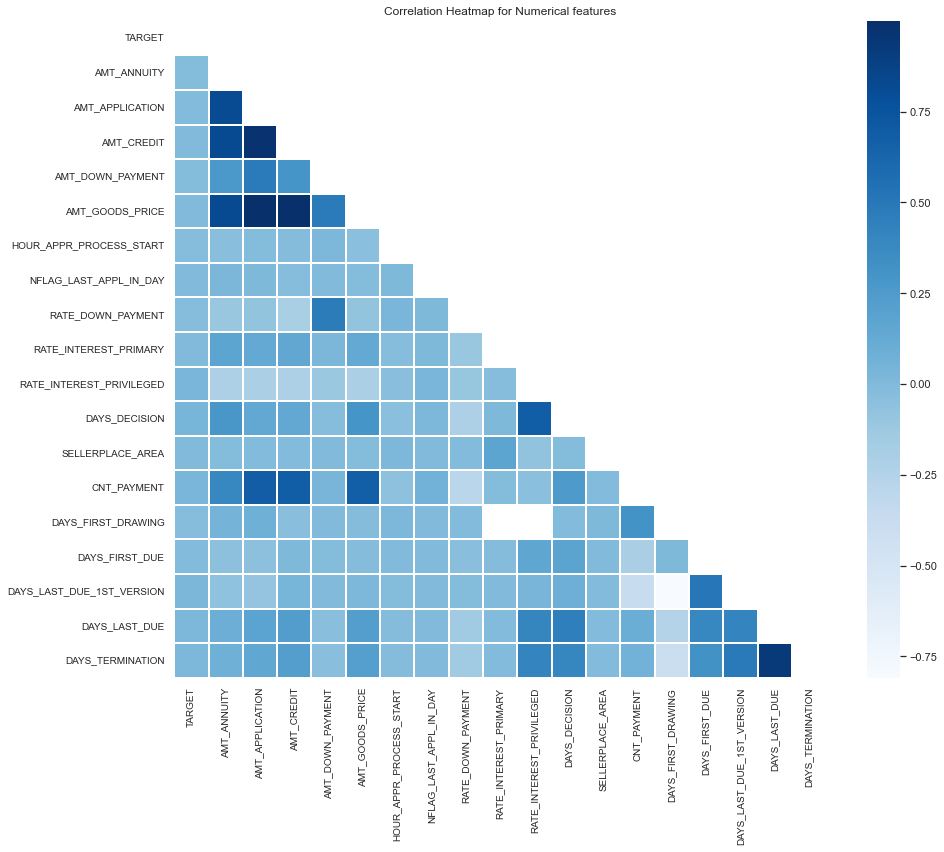

----------------------------------------------------------------------------------------------------


In [99]:
# Matrice de corrélation
corr_mat = correlation_matrix(prev_merged, ['SK_ID_CURR','SK_ID_PREV','NFLAG_INSURED_ON_APPROVAL'], cmap = 'Blues', figsize = (14,12))
corr_mat.plot_correlation_matrix()

### NAME_CONTRACT_TYPE

In [100]:
prev_merged['NAME_CONTRACT_TYPE'].value_counts()/prev_merged.shape[0]*100

Cash loans         43.824900
Consumer loans     43.719457
Revolving loans    11.283253
XNA                 0.021886
Name: NAME_CONTRACT_TYPE, dtype: float64

Total Number of categories of NAME_CONTRACT_TYPE = 5


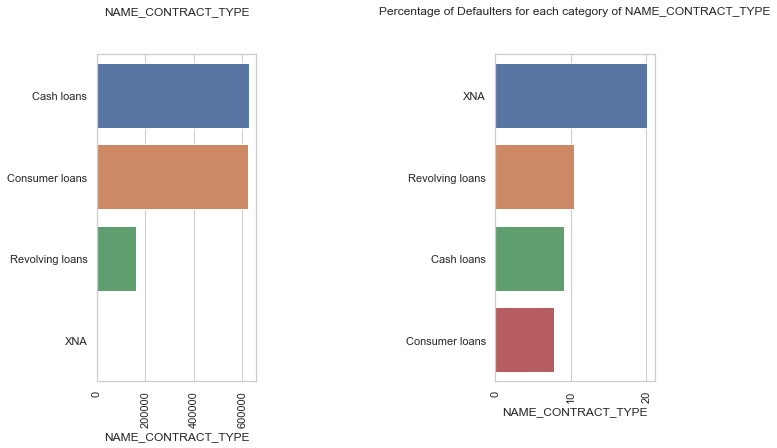

In [101]:
default_val_plotting(prev_merged,'NAME_CONTRACT_TYPE')

 * d'après le premier graphique, on voit que la majorité des prêts précédents étaient soit des prêts en espèces (environ 44 %) . 
 * 11,41% restants correspondent à des prêts renouvelables
 * il existe plusieurs prêts portant le nom XNA dont les types sont en fait inconnus, mais ils sont très peu nombreux.
 * en regardant la deuxième graphique, nous voyons que le taux de défaut pour le type de prêt XNA est le plus élevé, avec un taux de défaut de 20 %.

### NAME_CONTRACT_STATUS

In [102]:
prev_merged['NAME_CONTRACT_STATUS'].value_counts()/prev_merged.shape[0]*100

Approved        61.958249
Canceled        18.140761
Refused         17.158280
Unused offer     1.592205
Name: NAME_CONTRACT_STATUS, dtype: float64

Total Number of categories of NAME_CONTRACT_STATUS = 5


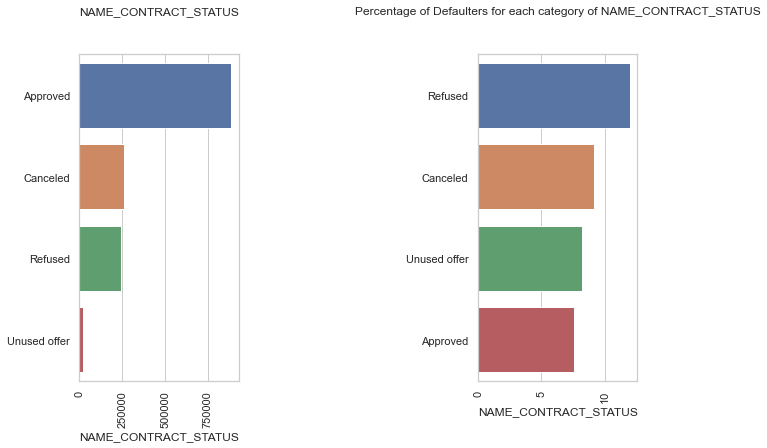

In [103]:
default_val_plotting(prev_merged,'NAME_CONTRACT_STATUS')
plt.savefig('image/contract status.png')

 * le type de statut de contrat le plus courant est 'Approved' ( environ 63 %) 
 * les deux statuts généraux suivants sont « Canceled » et « Refused », correspondant tous deux à environ 18 % des prêts. 
 * en regardant la deuxième sous-graphique pour le pourcentage de non-payeurs, nous voyons que les prêts qui ont été précédemment refusés ont tendance à avoir le taux de défaut le plus élevé parmi les prêts actuels. Ils correspondent à environ 12 % des non-payeurs de cette catégorie. Ils sont suivis du statut "Canceled", qui correspond à environ 9% du taux de défaut. 

### CODE_REJECT_REASON

In [104]:
prev_merged['CODE_REJECT_REASON'].value_counts()/prev_merged.shape[0]*100

XAP       80.098521
HC        10.207565
LIMIT      3.340407
SCO        2.281990
CLIENT     1.592205
SCOFR      0.760407
XNA        0.306121
VERIF      0.215291
SYSTEM     0.046988
Name: CODE_REJECT_REASON, dtype: float64

Total Number of categories of CODE_REJECT_REASON = 10


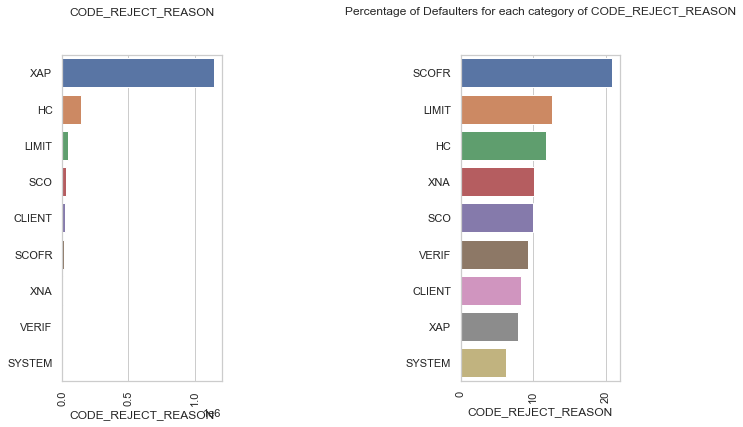

In [105]:
default_val_plotting(prev_merged,'CODE_REJECT_REASON')

 * le type de raison 'Refused' le plus courant est XAP (environ 81 %). 
 * 'HC' est la deuxième cause pour refuser (10,33%).
 * les candidats dont les demandes précédentes ont été rejetées par le code SCOFT ont le pourcentage le plus élevé de défaillants parmi eux (~ 21%). 
 * ensuite 'LIMIT' et 'HC', qui comptent environ 12,5 % et 12 % de défaillants.
 * la raison  XAP la plus courante correspond à seulement 7,5% de tous les non-payeurs et est le deuxième pourcentage le plus élevé de non-payeurs après le code SYSTEM.

### CHANNEL_TYPE

Cette colonne décrit comment le client a été attiré par le précédent prêt Home Credit.

In [106]:
prev_merged['CHANNEL_TYPE'].value_counts()/prev_merged.shape[0]*100

Credit and cash offices       41.977408
Country-wide                  29.581549
Stone                         12.831336
Regional / Local               6.465873
Contact center                 4.117805
AP+ (Cash loan)                3.469834
Channel of corporate sales     0.377302
Car dealer                     0.028389
Name: CHANNEL_TYPE, dtype: float64

Total Number of categories of CHANNEL_TYPE = 9


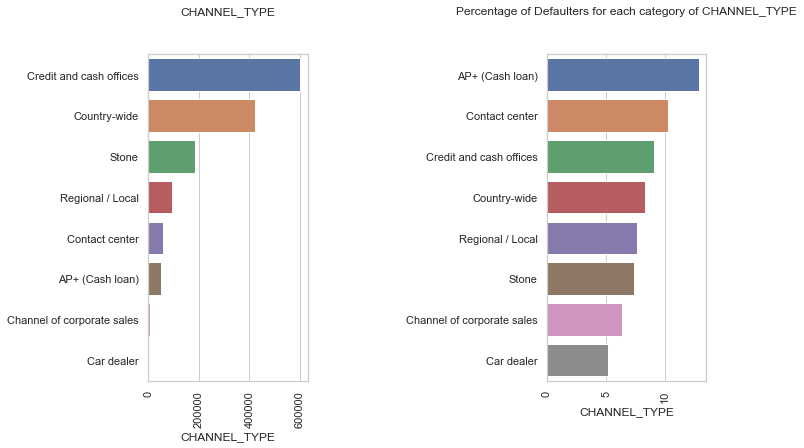

In [107]:
default_val_plotting(prev_merged,'CHANNEL_TYPE')
plt.savefig('image/chaneltype.png')

 * la majorité des demandes ont été reçues par les caisses et les bureaux de crédit, représentant environ 42,47% 
 * par le canal national, correspondant à 29,93% des demandes. 

 * le taux de défaut le plus élevé a été observé parmi les applications qui avaient un canal de type AP+ (prêt d'argent), ce qui correspondait à environ 13 % des défauts dans cette catégorie. Les autres canaux avaient des pourcentages par défaut inférieurs à celui-ci. Le canal des concessionnaires automobiles a affiché le pourcentage le plus faible de non-payeurs dans cette catégorie (seulement 5 %).

### PRODUCT_COMBINATION

Cette colonne fournit des détails sur la combinaison de produits des applications précédentes.

In [108]:
prev_merged['PRODUCT_COMBINATION'].value_counts()/prev_merged.shape[0]*100

Cash                              16.438848
POS household with interest       15.834927
POS mobile with interest          13.344707
Cash X-Sell: middle                8.393216
Cash X-Sell: low                   7.733358
Card Street                        6.614248
POS industry with interest         5.839087
POS household without interest     5.000787
Card X-Sell                        4.669004
Cash Street: high                  3.614923
Cash X-Sell: high                  3.552202
Cash Street: middle                2.093060
Cash Street: low                   1.999294
POS other with interest            1.420056
POS mobile without interest        1.390758
POS industry without interest      0.742647
POS others without interest        0.146488
Name: PRODUCT_COMBINATION, dtype: float64

In [109]:
default_val(prev_merged,'PRODUCT_COMBINATION')

Cash  9.5 %
POS household with interest  7.7 %
POS mobile with interest  8.8 %
Cash X-Sell: middle  7.8 %
Cash X-Sell: low  6.6 %
Card Street  11.3 %
POS industry with interest  6.3 %
POS household without interest  6.6 %
Card X-Sell  9.3 %
Cash Street: high  11.4 %
Cash X-Sell: high  11.5 %
Cash Street: middle  11.6 %
Cash Street: low  10.1 %
POS other with interest  8.1 %
POS mobile without interest  7.9 %
POS industry without interest  4.6 %
POS others without interest  7.2 %


Total Number of categories of PRODUCT_COMBINATION = 18


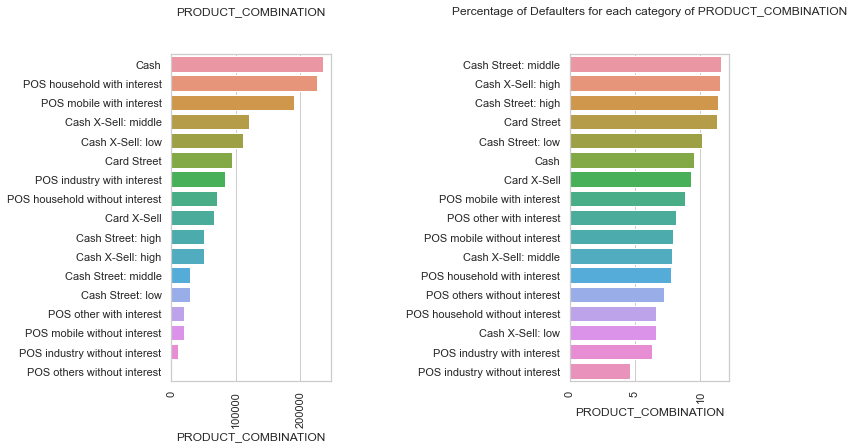

In [110]:
default_val_plotting(prev_merged,'PRODUCT_COMBINATION')

##### Les 3 types de combinaisons de produits les plus courants sont les espèces:
 * Cash                              16.438848
 * POS household with interest       15.834927
 * POS mobile with interest          13.344707

##### nous voyons la tendance par défaut la plus élevée parmi 
 * Cash Street: high  11.4 %
 * Cash X-Sell: high  11.5 %
 * Cash Street: middle  11.6 % 
 * le pourcentage le plus faible de non-payeurs dans l'industrie des points de vente sans taux d'intérêt, ce qui correspond à environ 4,5 % de non-payeurs    

### DAYS Features

Cette colonne indique le nombre de jours par rapport a la demande en cours lorsqu'une décision a été prise sur la demande précédente.

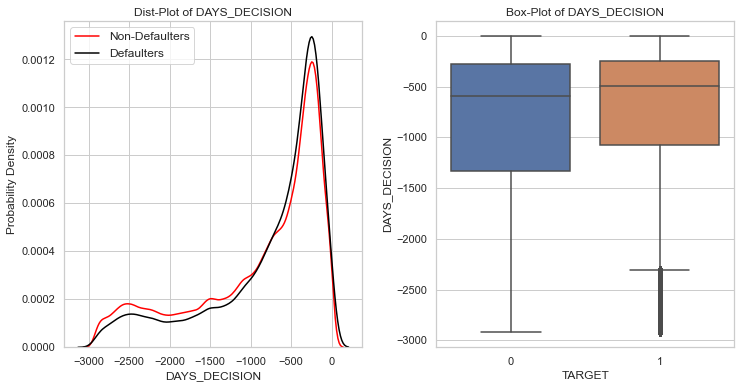

In [111]:
plot_continuous_variables(prev_merged, 'DAYS_DECISION', plots = ['distplot', 'box'], figsize = (12,6))

Dans le graphique on remarque que pour les non-payeurs, le nombre de jours avant la prise de décision est légèrement inférieur à celui des payeurs.

### DAYS_FIRST_DRAWING

Cette colonne indique le nombre de jours écoulés depuis le dépôt de la demande actuelle lorsque le premier paiement a été effectué sur la demande précédente.

In [112]:
# La stat général 
prev_merged.groupby(['TARGET'])['DAYS_FIRST_DRAWING'].describe(percentiles=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.25,0.5,0.75])

,count,mean,std,min,1%,2%,3%,4%,5%,6%,7%,8%,9%,10%,25%,50%,75%,max
TARGET,,,,,,,,,,,,,,,,,,
0,787893.0,341563.59375,87293.093750,-2922.0,-2457.0,-1187.00000,-671.000000,-394.000000,-250.0,-33.0,365243.0,365243.0,365243.0,365243.0,365243.0,365243.0,365243.0,365243.0
1,64702.0,332568.68750,104343.070312,-2919.0,-2354.0,-1096.97998,-694.969971,-492.959991,-365.0,-285.0,-234.0,-189.0,365243.0,365243.0,365243.0,365243.0,365243.0,365243.0


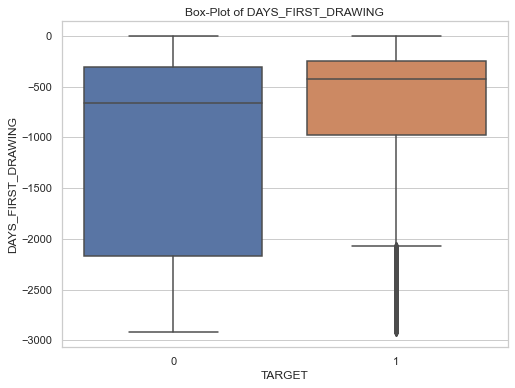

----------------------------------------------------------------------------------------------------


In [113]:
plot_continuous_variables(prev_merged, 'DAYS_FIRST_DRAWING', plots = ['box'], figsize = (8,6), scale_limits = [-3000,0])
print('-'*100)

pour la plupart des défaillants, le premier versement du crédit précédent a été effectué plus tôt que pour les non-défaillants. La valeur du 75-percentile pour les payeurs est également nettement inférieure à celle des non-payeurs

### DAYS_FIRST_DUE, DAYS_LAST_DUE_1ST_VERSION, DAYS_LAST_DUE, et DAYS_TERMINATION

In [114]:
# La stat général 
print("="*85)
print("Percentile Values for DAYS_FIRST_DUE")
print("-"*85)
print(prev_merged.groupby(['TARGET'])['DAYS_FIRST_DUE'].describe(percentiles=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.25,0.5,0.75]))
print("="*85)
print("Percentile Values for DAYS_LAST_DUE_1ST_VERSION") 
print("-"*85)
print(prev_merged.groupby(['TARGET'])['DAYS_LAST_DUE_1ST_VERSION'].describe(percentiles=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.25,0.5,0.75]))
print("="*85)
print("Percentile Values for DAYS_LAST_DUE")
print("-"*85)
print(prev_merged.groupby(['TARGET'])['DAYS_LAST_DUE'].describe(percentiles=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.25,0.5,0.75]))
print("="*85)
print("Percentile Values for DAYS_TERMINATION")
print("-"*85)
print(prev_merged.groupby(['TARGET'])['DAYS_TERMINATION'].describe(percentiles=[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.25,0.5,0.75]))

Percentile Values for DAYS_FIRST_DUE
-------------------------------------------------------------------------------------
           count          mean           std     min      1%      2%      3%  \
TARGET                                                                         
0       787893.0  13631.593750  72166.265625 -2892.0 -2820.0 -2761.0 -2704.0   
1        64702.0  11826.006836  67396.718750 -2891.0 -2801.0 -2725.0 -2658.0   

            4%      5%      6%      7%      8%      9%     10%     25%    50%  \
TARGET                                                                          
0      -2651.0 -2604.0 -2559.0 -2518.0 -2476.0 -2434.0 -2394.0 -1643.0 -832.0   
1      -2603.0 -2550.0 -2502.0 -2455.0 -2405.0 -2356.0 -2305.0 -1481.0 -748.0   

          75%       max  
TARGET                   
0      -411.0  365243.0  
1      -377.0  365243.0  
Percentile Values for DAYS_LAST_DUE_1ST_VERSION
-------------------------------------------------------------------------------

* en regardant les colonnes "Jours", on voit qu'elles contiennent des valeurs erronées et qu'il faut les remplacer pour qu'elles n'affectent pas notre modèle.

# 

# installments_payments.csv

Ce tableau répertorie l'historique de remboursement de chaque prêt que le demandeur avait contracté auprès de Home Credit Group. Le tableau contient des caractéristiques telles que le montant du paiement, le montant payé par le client pour chaque paiement, etc.

In [115]:
# La stat générale 
print(f'La dimension du dataset: {installments_payments.shape}')
print('-'*100)
print(f'Le nombre d\'unique SK_ID_PREV: {len(installments_payments.SK_ID_PREV.unique())}')
print(f'Le nombre d\'unique SK_ID_CURR: {len(installments_payments.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Les nombres communs SK_ID_CURR dans application_train.csv et installments_payments.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print(f'Les nombres communs SK_ID_CURR dans application_test.csv et  installments_payments.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(installments_payments.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Le nombre des valeurs doublons: {installments_payments.shape[0] - installments_payments.duplicated().shape[0]}')
print('-'*100)
display(installments_payments.head(5))

La dimension du dataset: (13605401, 8)
----------------------------------------------------------------------------------------------------
Le nombre d'unique SK_ID_PREV: 997752
Le nombre d'unique SK_ID_CURR: 339587
----------------------------------------------------------------------------------------------------
Les nombres communs SK_ID_CURR dans application_train.csv et installments_payments.csv are: 291643
Les nombres communs SK_ID_CURR dans application_test.csv et  installments_payments.csv are: 47944
----------------------------------------------------------------------------------------------------
Le nombre des valeurs doublons: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [116]:
# Les valeurs NaN
plt.figure(figsize=(8,6))
missing_values(installments_payments, plot=False);

Number of Variables include Missing Values: 2 

              Feature  Num_Missing  Missing_Ratio DataTypes
0  DAYS_ENTRY_PAYMENT         2905       0.000214   float16
1         AMT_PAYMENT         2905       0.000214   float32 



<Figure size 576x432 with 0 Axes>

 * Il n'y a que 2/8 colonnes qui contiennent des valeurs NaN ( 0,02 %)

In [117]:
# Fusionnons les TARGETS de la table application_train avec la table installments_payments
installments_merged = application_train.iloc[:,:2].merge(installments_payments, on = 'SK_ID_CURR', how = 'left')

----------------------------------------------------------------------------------------------------


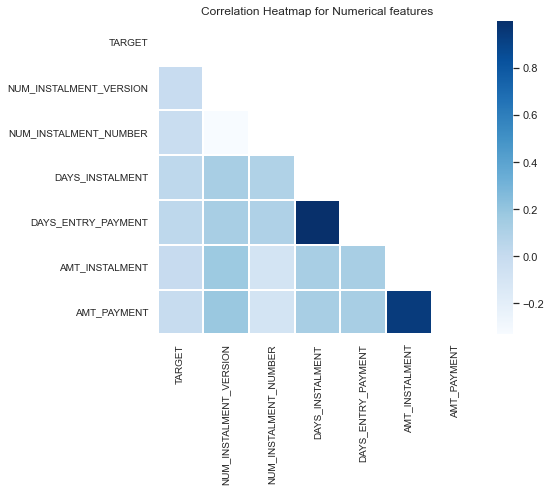

----------------------------------------------------------------------------------------------------


In [118]:
# Matrice de correlation Matrix 
corr_mat = correlation_matrix(installments_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (8,7))
corr_mat.plot_correlation_matrix()


###### on voit une paire de variables hautement corrélées:
 * AMT_INSTALMENT et AMT_PAYMENT
 * DAYS_INSTALMENT et DAYS_ENTRY_PAYMENT
 
###### la corrélation des variables avec la cible n'est pas perceptible (l'absence d'une relation linéaire entre les variables et TARGET).    

### DAYS_INSTALMENT

Cette colonne répertorie les jours quand le versement du credit précédent était dû.

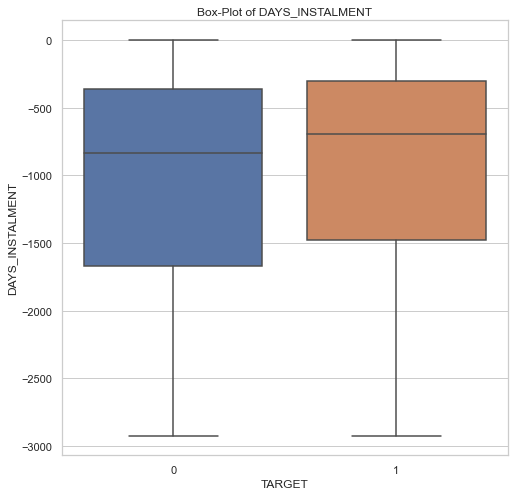

In [119]:
plot_continuous_variables(installments_merged, 'DAYS_INSTALMENT', plots = ['box'], figsize = (8,8))

### DAYS_ENTRY_PAYMENT

Cette colonne répertorie les jours où une partie du prêt précédent a effectivement été remboursée.

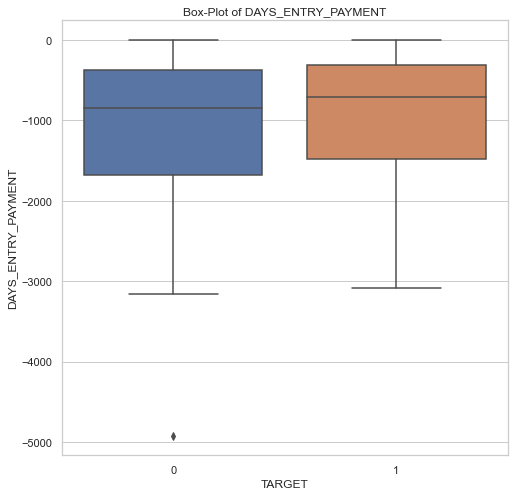

In [120]:
plot_continuous_variables(installments_merged, 'DAYS_ENTRY_PAYMENT', plots = ['box'], figsize = (8,8))
del installments_merged

les défaillants ont tendance à avoir moins de jours depuis leur dernier paiement, tandis que les non-défaillants ont plus de jours depuis leurs derniers paiements. Tous les quantiles de défaillants ont des jours plus récents que ceux des non-défaillants.

# 

# POS_CASH_balance.csv

Ce tableau contient les aperçus mensuels du solde des points de vente et des prêts en espèces antérieurs que le demandeur avait avec Home Credit Group. Le tableau contient des colonnes telles que le statut du contrat, le nombre de versements restants, etc.

In [121]:
# La stat générale 
print(f'La dimension du dataset: {POS_CASH_balance.shape}')
print('-'*100)
print(f'Le nombre d\'unique SK_ID_PREV: {len(POS_CASH_balance.SK_ID_PREV.unique())}')
print(f'Le nombre d\'unique SK_ID_CURR: {len(POS_CASH_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Les nombres communs SK_ID_CURR dans application_train.csv et POS_CASH_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print(f'Les nombres communs SK_ID_CURR dans application_test.csv et POS_CASH_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(POS_CASH_balance.SK_ID_CURR.unique())))}')
print('-'*100)
print(f'Le nombre des valeurs doublons: {POS_CASH_balance.shape[0] - POS_CASH_balance.duplicated().shape[0]}')
print('-'*100)
display(POS_CASH_balance.head())

La dimension du dataset: (10001358, 8)
----------------------------------------------------------------------------------------------------
Le nombre d'unique SK_ID_PREV: 936325
Le nombre d'unique SK_ID_CURR: 337252
----------------------------------------------------------------------------------------------------
Les nombres communs SK_ID_CURR dans application_train.csv et POS_CASH_balance.csv are: 289444
Les nombres communs SK_ID_CURR dans application_test.csv et POS_CASH_balance.csv are: 47808
----------------------------------------------------------------------------------------------------
Le nombre des valeurs doublons: 0
----------------------------------------------------------------------------------------------------


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [122]:
# Les valeurs NaN
plt.figure(figsize=(8,6))
missing_values(POS_CASH_balance, plot=False);

Number of Variables include Missing Values: 2 

                 Feature  Num_Missing  Missing_Ratio DataTypes
0  CNT_INSTALMENT_FUTURE        26087       0.002608   float16
1         CNT_INSTALMENT        26071       0.002607   float16 



<Figure size 576x432 with 0 Axes>

 * 2/8 colonnes qui contiennent des valeurs NaN Ces colonnes représentent le nombre de paiements restants et la durée du prêt.

In [123]:
# Fusionnons les TARGETS de la table application_train avec la table POS_CASH_balance
pos_cash_merged = application_train.iloc[:,:2].merge(POS_CASH_balance, on = 'SK_ID_CURR', how = 'left')

----------------------------------------------------------------------------------------------------


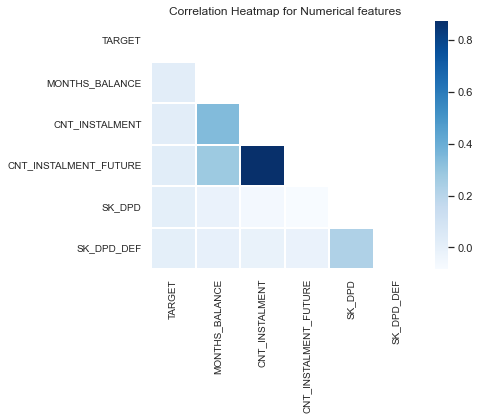

----------------------------------------------------------------------------------------------------


In [124]:
# Matrice de corrélation 
corr_mat = correlation_matrix(pos_cash_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (7,6))
corr_mat.plot_correlation_matrix()

 * la corrélation des variables avec la cible est très faible, cela montre l'absence de relation linéaire entre les variables et la variable cible.

In [125]:
# on va regrouper par le variable "SK_ID_PREV" et agréger avec la moyenne pour obtenir une ligne moyenne pour chaque prêt précédent 
pos_cash_merged = pos_cash_merged.groupby('SK_ID_PREV').mean()

### CNT_INSTALMENT_FUTURE

Cette colonne indique le nombre de versements restant jusqu'au remboursement du prêt précédent.

In [ ]:
plot_continuous_variables(pos_cash_merged, 'CNT_INSTALMENT_FUTURE', plots = ['box'], figsize = (8,8))
del pos_cash_merged

on voit que les valeurs de  50-percentile  pour les défaillants sont généralement plus élevées que celles des non-défaillants. Même la limite supérieure des moustaches pour les défaillants est supérieure à celle des non-défaillants. Cela suggère que les défaillants ont tendance à avoir plus de versements restants sur leurs crédits précédents par rapport aux non-défaillants.

In [ ]:
# garbage collection
import gc   
gc.collect()

# 

# credit_card_balance.csv

Ce tableau se compose de données mensuelles associées à une ou plusieurs cartes de crédit que le demandeur avait avec Home Credit Group. Le tableau contient des champs tels que le solde, la limite de crédit, le montant du versements, etc.

In [ ]:
# La stat générale 
print(f'La dimension du dataset: {credit_card_balance.shape}')
print('-'*100)
print(f'Le nombre d\'unique SK_ID_PREV {len(credit_card_balance.SK_ID_PREV.unique())}')
print(f'Le nombre d\'unique SK_ID_CURR: {len(credit_card_balance.SK_ID_CURR.unique())}')
print('-'*100)
print(f'Les nombres communs SK_ID_CURR dans application_train.csv et credit_card_balance.csv are: {len(set(application_train.SK_ID_CURR.unique()).intersection(set(credit_card_balance.SK_ID_CURR.unique())))}')
print(f'Les nombres communs SK_ID_CURR dans application_test.csv et credit_card_balance.csv are: {len(set(application_test.SK_ID_CURR.unique()).intersection(set(credit_card_balance.SK_ID_CURR.unique())))}')
print('-'*100)

print(f'Le nombre des valeurs doublons {credit_card_balance.shape[0] - credit_card_balance.duplicated().shape[0]}')
print('-'*100)
display(credit_card_balance.head())

In [ ]:
# Les valeurs NaN
plt.figure(figsize=(8,6))
missing_values(credit_card_balance, plot=True);

In [ ]:
# Fusionnons les TARGETS de la table application_train avec la table credit_card_balance
cc_balance_merged = application_train.iloc[:,:2].merge(credit_card_balance, on = 'SK_ID_CURR', how = 'left')

In [ ]:
# Matrice de correlation
corr_mat = correlation_matrix(cc_balance_merged, ['SK_ID_CURR','SK_ID_PREV'], figsize = (13,11))
corr_mat.plot_correlation_matrix()

###### nous voyons plusieurs paires de fonctions hautement corrélées:
 * AMT_RECEIVABLE_PRINCIPLE, AMT_RECIVABLE, AMT_TOTAL_RECEIVABLE et AMT_BALANCE
 * on voit également une forte corrélation entre ces 3 colonnes AMT_RECEIVABLE,AMT_PAYMENT_TOTAL_CURRENT et AMT_PAYMENT_CURRENT

##### La corrélation des variables avec la cible n'est pas perceptible, cela indique l'absence d'une relation linéaire entre la caractéristique et la variable cible.

In [ ]:
# on va regrouper par le champ "SK_ID_PREV" et agréger avec la moyenne pour obtenir une ligne moyenne pour chaque prêt 
cc_balance_merged = cc_balance_merged.groupby('SK_ID_PREV').mean()

### AMT_BALANCE

Cette colonne indique le montant moyen du solde qu'une personne avait généralement sur son compte de carte de crédit pour un prêt précédent.

In [ ]:
plot_continuous_variables(cc_balance_merged, 'AMT_BALANCE', plots = ['box'], figsize = (8,8))

D'après le graphique ci-dessus, on peut voir que les défaillants ont une valeur plus élevée d'AMT_BALANCE par rapport aux non-défaillants. Ils montrent des valeurs plus élevées de tous les quantiles et même des moustaches. Cela pourrait impliquer que le montant du crédit pour les défaillants pourrait également être relativement plus élevé par rapport aux non-défaillants.

### AMT_TOTAL_RECEIVABLE

Cette colonne décrit la moyenne du montant total à recevoir sur le crédit précédent.

In [ ]:
plot_continuous_variables(cc_balance_merged, 'AMT_TOTAL_RECEIVABLE', plots = ['violin'], figsize = (8,8))

 * on voit comportement similaire à celui observé avec d'autres montants également, à savoir que les défaillants avaient généralement un montant à recevoir plus élevé sur leur crédit précédent, ce qui peut impliquer les montants de crédits plus élevés qu'ils ont pu prendre.

### INSTALMENT_MATURE_CUM

La colonne indique le nombre moyen de remboursement effectués sur les prêts précédents.

In [ ]:
plot_continuous_variables(cc_balance_merged, 'CNT_INSTALMENT_MATURE_CUM', plots = ['box'], figsize = (8,8))


 * les défaillants paient généralement moins  sur leur prêt précédent.

In [ ]:
del application_train, application_test,\
          bureau, bureau_balance, credit_card_balance, \
          installments_payments, \
          POS_CASH_balance, previous_application

## Conclusion 

 * les datasets devraient être  combiné d'une manière originale pour que les données combinées aient un sens.
 * certaines catégories établissent une distinction très claire entre les payeurs et les non-payeurs, ce qui peut être important à des fins de classification.
 * il existe plusieurs variables numériques  qui contiennent des  d'erreurs
 * certaines variables sont  corrélées qui augmentaient simplement la dimensionnalité des données et n'ajoutaient pas beaucoup de valeur
 * l'ensemble de données est déséquilibré
 * les défaillants ont des comportements anormaux lors de la prévision du risque de défaut, et nous ne pouvons donc pas supprimer les valeurs aberrantes car ils peuvent indiquer une tendance importante vers le défaut.